The goal of this project is to analyze data about the
passengers aboard the Titanic with the intent of creating
models to predict who would survive and who wouldn't based
on the correlations and relationships we determine through
our aforementioned analysis of the data.

First, we need to import the Python packages that we will
be using to analyze the data and create our models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, \
    f1_score, plot_roc_curve
from sklearn.model_selection import train_test_split, KFold

Now, let us load our training and testing data
from their respective .csv files and save them as
separate DataFrame objects.

In [2]:
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")

Before we clean our data, we should determine the lengths
of each of the data sets and print the first few entries
from both DataFrame objects in order to ensure the data
has been loaded properly and without issue.

In [3]:
print(f"Length of Test Data: {len(test_data)}")
print(f"Length of Training Data: {len(train_data)}")

Length of Test Data: 418
Length of Training Data: 891


In [4]:
print("Test Data:")
test_data.head()

Test Data:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
print("Training Data:")
train_data.head()

Training Data:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now, we can begin cleaning both data sets; let's start
with the training data.

First, we should check how many null (NaN) values each
column in the data has.

In [6]:
print(f"Training Data Nulls:\n{train_data.isnull().sum()}")

Training Data Nulls:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Based on the description of the null (NaN) values in the
training data set, it appears that the "Embarked" field
only contains 2 null values. Because this number is
relatively low, we can simply delete the rows associated
with these NA values without losing a significant portion
of our data.

In [7]:
train_data = train_data.dropna(subset=["Embarked"])
print(f"Training Data Nulls:\n{train_data.isnull().sum()}")

Training Data Nulls:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


Now that we have dropped the rows with null values in
the "Embarked" field, we need to consider how we should
impute the NaN values in the "Age" and "Cabin" fields:
the numbers of null values in these two fields are too
large to simply delete the associated rows as doing so
would greatly reduce the amount of data we have to work
with, so much so that the results of any performed analyses
may not closely reflect the relationships and correlations
between fields, thus making our predictive models less
accurate.

Let us try to tackle the "Age" field first; we can use
mean value imputation for the null values in this column.
Using mean value imputation will not impact the mean of
the entire "Age" series, and the effect on any predictive
forecasts we create using our predictive models will be muted
(Skiena, Page 77).

In [8]:
train_data["Age"].fillna(value=train_data["Age"].mean(), inplace=True)
print(f"Training Data Nulls:\n{train_data.isnull().sum()}")

Training Data Nulls:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


The only series left in the training data that has
null values is the "Cabin" field. However, cleaning
this field will be a bit more difficult than one might
think at first glance. After looking through the data
set, it appears that the entries in the "Cabin" field
use textual data as well as numeric data in the form
of strings. Imputing these null values would be extremely
difficult. In fact, after a quick Internet search, I found
a webpage that lists the cabin numbers assigned to different
passengers on the Titanic. However, even though there was
a large amount of data about the cabin allocations for
first class passengers, there was a gross lack of data
about second class and third class passengers (the webpage
I was referring to had URL
https://www.encyclopedia-titanica.org/cabins.html ).
Although it may seem apparent that we cannot do anything with
the "Cabin" series data, there is another way of looking at
the issue: can we somehow use the fact that many records are
missing cabin entries itself as a form of data? More specifically,
can we determine if there is a relation between the data in a
record's "Cabin" field and the related passenger's survival,
including NaN and non-NaN data?

It sounds strange, but perhaps the best way to deal with the "Cabin"
series data, at this point in the project could be to simply leave it
as is: we will deal with this field of the data in a more
tactical manner, one that will allow us to extract the relevant
information without altering the missing data or removing the field
from the data entirely.

Let us now start to check the data for outliers, specifically the "Fare"
series. One price that sticks out in my mind as not being very realistic
is a price of zero. Let's count the number of such records in the data.

In [9]:
train_data_fare = train_data["Fare"]
print(f"Training Data Zero Fare Record Count: {train_data_fare[train_data_fare == 0].count()}")

Training Data Zero Fare Record Count: 15


It looks like there are 15 records in the "Fare" series that have
zero amount fares. If we assume that these entries are outliers,
then we might be able to simply remove their associated records
from the data set. However, let us print each of these suspected
outlier records. A fare of zero for a ticket to board the Titanic,
while unlikely, is not impossible; if there are other fields in these
records with strange-looking entries, though, then we can deduce
that they are in fact outliers.

In [10]:
print("Training Data Zero Fare Records:")
train_data[train_data["Fare"] == 0].head(15)

Training Data Zero Fare Records:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.000000,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.000000,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.000000,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,29.642093,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.000000,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,29.642093,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,29.642093,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,29.642093,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.000000,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,29.642093,0,0,112052,0.0,NaN,S


The data printed in the previous step all seem to be outliers: every
third class ticket received at a zero fare has the word "LINE" written
in the "Ticket" field, and the rest of the zero-cost tickets are either
second class or first class tickets.

Before we go ahead and remove all these data entries, let us determine
the mean fare prices for each class of ticket. Based on this comparison,
we can decide which entries should be removed and which should remain.

In [11]:
train_data_nonzero_fare = train_data[train_data["Fare"] != 0]
train_data_nonzero_fare_grouped = train_data_nonzero_fare.groupby("Pclass")["Fare"].mean()
print(f"Training Data Mean Non-zero Fare Prices, Grouped by Ticket Class:\n{train_data_nonzero_fare_grouped}")

Training Data Mean Non-zero Fare Prices, Grouped by Ticket Class:
Pclass
1    86.207715
2    21.358661
3    13.787875
Name: Fare, dtype: float64


Based on this most recent step, it appears that when zero fare tickets
are not considered, the mean price of a first class ticket was
86.207715, the mean price of a second class ticket was 21.358661, and
the mean price of a third class ticket was 13.787875. Therefore, it doesn't
make sense that of the 15 people who supposedly had free tickets, 11 of them
possessed either second class or third class tickets, the costs of which
seemed to be significantly higher (when considering the value of money
at the time of the Titanic's maiden voyage). Thus, between the
strange "LINE" entries in the third class passenger "Ticket" fields and
the fact that the rest are second and first class tickets, we should
probably drop all 15 of these records, considering them outliers.

In [12]:
train_data = train_data[train_data["Fare"] != 0]
print(f"Training Data Length: {len(train_data)}")

Training Data Length: 874


Let us now remove any duplicates that may be present in the data.

In [13]:
train_data = train_data.drop_duplicates()
print(f"Training Data Length: {len(train_data)}")

Training Data Length: 874


It appears that there were no duplicates in the data.

Now, before we start analyzing the data, we should consider
engineering some current features into new features. First, let's
circle back to the "Cabin" field in the data. Even though many of the
records have NaN values in for this column, we can potentially use
this fact to our advantage by counting splitting the data into two
categories: one containing only the deck letter, and the other
containing only the cabin/suite number. Both of these new features
will deal with NaN values as they come.

Let's start by creating a DataFrame to store our newly engineered features,
the first being a series containing a list of the deck letters each person
has a cabin/suite on. This can be done using a lambda function.

In [14]:
# Use a lambda function to split each entry in the "Cabin" field,
# and store it in a separate temporary storage DataFrame.
temp = train_data["Cabin"].apply(lambda entry: [] if pd.isnull(entry)
                                 else entry.split(" "))

In [15]:
# Define a function to take only the deck letters from each entry.
def get_letters(obj):
    for index in range(0, len(obj)):
        obj[index] = str(obj[index])[0]

    return obj

In [16]:
# Apply our newly defined function to the temp DataFrame
# and print the results using the head(50) function.
temp = temp.apply(lambda cabin_list : [] if (cabin_list == [])
                  else get_letters(cabin_list))
temp.head(50)

0            []
1           [C]
2            []
3           [C]
4            []
5            []
6           [E]
7            []
8            []
9            []
10          [G]
11          [C]
12           []
13           []
14           []
15           []
16           []
17           []
18           []
19           []
20           []
21          [D]
22           []
23          [A]
24           []
25           []
26           []
27    [C, C, C]
28           []
29           []
30           []
31          [B]
32           []
33           []
34           []
35           []
36           []
37           []
38           []
39           []
40           []
41           []
42           []
43           []
44           []
45           []
46           []
47           []
48           []
49           []
Name: Cabin, dtype: object

Now that we have found a way to separate the letter data from the
numeric data in the "Cabin" series, we might be able to create features
that we can use in our model.

Let us try to determine how many passengers had cabins on more than
one deck of the ship.

In [17]:
temp_counts = temp.apply(lambda cabin_list : 0 if (cabin_list == [])
                                        else len(np.unique(cabin_list)))

We should check to make sure our new feature has been successfully
created and filled in with data.

In [18]:
temp_counts.head(50)

0     0
1     1
2     0
3     1
4     0
5     0
6     1
7     0
8     0
9     0
10    1
11    1
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    1
22    0
23    1
24    0
25    0
26    0
27    1
28    0
29    0
30    0
31    1
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
Name: Cabin, dtype: int64

Our new feature seems to have been created and filled successfully.
However, before we decide to go ahead and add it to the training
data, we should determine if the information it contains is actually
meaningful. For example, if all the records have either a 0 or a 1
for this new field, then it doesn't make sense to include it as
such a result would mean that all records where the cabin data was
not NaN contains cabins in only one deck of the ship.

In [19]:
print(f"Different Cabin Deck Counts by Passenger:\n{temp_counts.value_counts()}")

Different Cabin Deck Counts by Passenger:
0    675
1    195
2      4
Name: Cabin, dtype: int64


Based on our previous step, it appears that of the 199 records with
non-NaN cabin data, only 4 of them represented passengers who owned
cabins on two decks, while the rest only owned cabins on one deck
(The data suggests that there were no known passengers on the Titanic
who owned cabins on three or more decks). Therefore, our experiment seems
to have produced a result that is not of sufficient meaning to include
in our model.

Despite this, we should continue to look into the cabin data we collected
and stored in the temp DataFrame. One other place we can look is
at the deck letters themselves: did survival during the sinking of the
Titanic have anything to do with the deck a person's cabin was located on?

Let's try to edit our previous temp DataFrame by making each entry
contain the dominant deck letter. This applies specifically to the four
known passengers on the Titanic who owned cabins on more than one deck; the
dominant deck letter refers to the deck on which these passengers owned the
majority of their cabins. In the event that the passenger owns the same number
of cabins on each deck - one cabin on deck A and another on deck B - then we
will use the higher level cabin (the cabin with the deck closest to
the top of the ship, and therefore the deck letter closest to "A").

In [20]:
print(temp[(temp.apply(lambda cabin_list : 0 if (cabin_list == [])
                       else len(np.unique(cabin_list)))) == 2])

75     [F, G]
128    [F, E]
699    [F, G]
715    [F, G]
Name: Cabin, dtype: object


Based on the previous step, it appears that all of the passengers
who owned cabins on multiple decks have the same number of cabins
on each of the associated decks. Thus, none of these records
have a dominant deck letter, based on our previous definition of the
term. Thus, instead of picking the deck letters closest to "A," it
might actually be better to remove these four entries from the data
altogether. We can do this by adding this experimental feature to
our original data set, deleting these four rows based on the values
in this new field, and then removing this experimental field from
the data set.

In [21]:
# add experimental feature as new data field.
train_data["Dcounts"] = temp_counts

In [22]:
# print initial length of data set before removing multi-deck passengers,
# then remove records with cabins on multiple decks.
print(f"Initial Training Data Length: {len(train_data)}")
train_data = train_data[train_data.Dcounts != 2]

Initial Training Data Length: 874


In [23]:
# print the length of the edited data set,
# drop the "Dcounts" field from the data,
# and use the head(10) function to print the top 10 data records.
print(f"New Training Data Length: {len(train_data)}")
train_data.drop(columns="Dcounts", inplace=True)
train_data.head(10)

New Training Data Length: 870


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,29.642093,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,NaN,C


We can now focus on creating a deck letter field. Let us once again
utilize a temporary storage DataFrame so we can be sure our new
feature is meaningful enough in its content to include as some
type of categorical data field, like an indicator variable. We should
edit the temp DataFrame to include only the first index of each of the
deck letter lists it contains.

In [24]:
temp = temp.apply(lambda cabin_list : "NaN" if (cabin_list == [])
                  else str(cabin_list[0]))
temp.head(25)

0     NaN
1       C
2     NaN
3       C
4     NaN
5     NaN
6       E
7     NaN
8     NaN
9     NaN
10      G
11      C
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21      D
22    NaN
23      A
24    NaN
Name: Cabin, dtype: object

Let's now try to determine if the information this new experimental
feature contains is meaningful enough to include as a field in our
data set.

In [25]:
train_data["Dletter"] = temp
print(f"Training Data Survival by Deck Letter:\n{train_data.groupby(['Survived', 'Dletter'])['PassengerId'].count()}")

Training Data Survival by Deck Letter:
Survived  Dletter
0         A            7
          B           10
          C           24
          D            8
          E            8
          F            2
          G            2
          NaN        470
          T            1
1         A            7
          B           33
          C           35
          D           25
          E           24
          F            7
          G            2
          NaN        205
Name: PassengerId, dtype: int64


Based on the grouped data we just printed, it looks like
this feature does have some meaningful implications: a large
portion of passengers known to be on decks B, C, D, and E survived.
Therefore, we should keep this as a new field int the training data.

After a review of the "Ticket" field of the data, we have come to
the conclusion that it is redundant: passengers can be identified
by the names or their passenger ID's, so having another means of
identification seems to be a waste of memory. Therefore, we can
drop the "Ticket" field from the data.

Furthermore, we should probably drop the "Cabin" series
from our data as well. The reasoning for this is similar
to how we justified dropping the "Ticket" data as well:
we have obtained everything that we feel is useful from this
specific data field, so it makes sense to drop what we don't need.
Furthermore, the large number of NaN values that remain in the
"Cabin" field may cause issues when it comes to analyzing the
data if we don't get rid of it.

In [26]:
train_data.drop(columns=["Ticket", "Cabin"], inplace=True)
train_data.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Dletter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.2500,S,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.9250,S,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.1000,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,8.0500,S,NaN
5,6,0,3,"Moran, Mr. James",male,29.642093,0,0,8.4583,Q,NaN
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,51.8625,S,E
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,21.0750,S,NaN
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,11.1333,S,NaN
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,30.0708,C,NaN


One last thing I'd like to do is create histograms for all the
numeric non-categorical data features in our current version
of the data set (excluding "Tnum"). This will help us determine if there are any
series in the data that we need to somehow normalize.

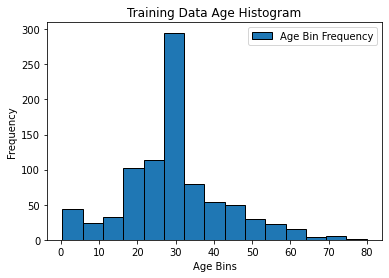

In [27]:
# plot "Age" series histogram.
plt.hist(train_data["Age"],
         bins=15,
         edgecolor="black",
         label="Age Bin Frequency")
plt.title("Training Data Age Histogram")
plt.xlabel("Age Bins")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

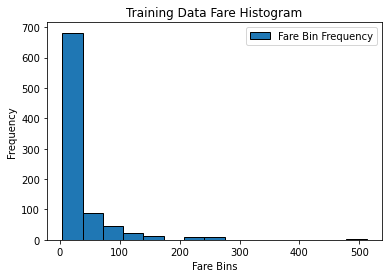

In [28]:
# plot "Fare" series histogram.
plt.hist(train_data["Fare"],
         bins=15,
         edgecolor="black",
         label="Fare Bin Frequency")
plt.title("Training Data Fare Histogram")
plt.xlabel("Fare Bins")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

Based on what we've learned in class, the "Age" series
looks somewhat normal, but the "Fare" series data seems
to be much closer to a power law distribution than
a normal distribution. Therefore, we should probably
normalize the data by taking the logarithm of it.

In [29]:
# create a "log(Fare)" feature
# and drop the original "Fare" feature.
train_data["log(Fare)"] = np.log(train_data["Fare"])
train_data.drop(columns="Fare",
                inplace=True)

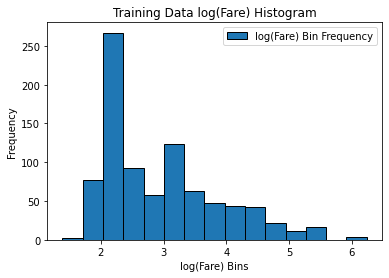

In [30]:
# plot the "log(Fare)" histogram.
plt.hist(train_data["log(Fare)"],
         bins=15,
         edgecolor="black",
         label="log(Fare) Bin Frequency")
plt.title("Training Data log(Fare) Histogram")
plt.xlabel("log(Fare) Bins")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

After taking the logarithm of the "Fare" series data, it looks
much more normally distributed.

At this point, we need to perform the same transformations on the
test data. First, let's see where the NaN values are in the
test data set.

In [31]:
print(f"Test Data Nulls:\n{test_data.isnull().sum()}")

Test Data Nulls:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


It looks like there is one NaN entry in the "Fare" series. Because
there's only one, we should have enough data left if we drop said
record, so this is what we'll do.

In [32]:
print(f"Initial Test Data Length: {len(test_data)}")
test_data.dropna(subset=["Fare"],
                 inplace=True)
print(f"New Test Data Length: {len(test_data)}")

Initial Test Data Length: 418
New Test Data Length: 417


Next, we should deal with the 86 NaN values in the "Age" series:
let us once again use mean imputation.

In [33]:
test_data["Age"].fillna(value=test_data["Age"].mean(), inplace=True)
print(f"Test Data Nulls:\n{test_data.isnull().sum()}")

Test Data Nulls:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          326
Embarked         0
dtype: int64


Now we must deal with the records with NaN values in the "Cabin" series.
We can do this by engineering the same features we did in the training
data and replacing this field with something more meaningful.

First, let's determine how many passengers in the test data owned
cabins on two or more different decks.

In [34]:
# use the same first lambda function from our work with the
# training data to split each cabin entry into a list of strings.
temp = test_data["Cabin"].apply(lambda entry: [] if pd.isnull(entry)
                                 else entry.split(" "))

In [35]:
# use the same second lambda function (and our get_letters()
# function) from our work wit the training data to make each
# cabin list entry a list of only the deck numbers of each cabin.
temp = temp.apply(lambda cabin_list : [] if (cabin_list == [])
                  else get_letters(cabin_list))
temp.head(50)

0               []
1               []
2               []
3               []
4               []
5               []
6               []
7               []
8               []
9               []
10              []
11              []
12             [B]
13              []
14             [E]
15              []
16              []
17              []
18              []
19              []
20              []
21              []
22              []
23              []
24    [B, B, B, B]
25              []
26             [B]
27              []
28             [A]
29              []
30              []
31              []
32              []
33              []
34             [C]
35              []
36              []
37              []
38              []
39              []
40              []
41             [D]
42              []
43              []
44             [D]
45              []
46             [A]
47              []
48             [D]
49              []
Name: Cabin, dtype: object

In [36]:
# apply the same third lambda function as we used in our work
# on the training data to determine how many unique decks
# each passenger owned a cabin on.
temp_counts = temp.apply(lambda cabin_list : 0 if (cabin_list == [])
                                        else len(np.unique(cabin_list)))

In [37]:
# determine how how many passengers owned cabins on more than one deck.
print(f"Different Cabin Deck Counts by Passenger:\n{temp_counts.value_counts()}")

Different Cabin Deck Counts by Passenger:
0    326
1     88
2      3
Name: Cabin, dtype: int64


Based on these most recent steps, it looks like there are three
passengers who owned cabins on two different decks of the ship:
none owned cabins on three or more decks. Let us once again
deal with such entries by removing them from the data.

In [38]:
# add deck count field to test data.
test_data["Dcounts"] = temp_counts

In [39]:
# print initial length of data set before removing multi-deck passengers,
# then remove records with cabins on multiple decks.
print(f"Initial Test Data Length: {len(test_data)}")
test_data = test_data[test_data.Dcounts != 2]

Initial Test Data Length: 417


In [40]:
# print the length of the edited data set,
# drop the "Dcounts" field from the data,
# and use the head(10) function to print the top 10 data records.
print(f"New Test Data Length: {len(test_data)}")
test_data.drop(columns="Dcounts", inplace=True)
test_data.head(10)

New Test Data Length: 414


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


Next, we should add the "Dletters" feature that we previously
engineered for the training data to the test data as well.

In [41]:
temp = temp.apply(lambda cabin_list : "NaN" if (cabin_list == [])
                  else str(cabin_list[0]))
temp.head(25)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12      B
13    NaN
14      E
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24      B
Name: Cabin, dtype: object

Now, let's add this feature as a new field to the test data.

In [42]:
test_data["Dletter"] = temp
test_data.head(20)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Dletter
0,892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.8292,NaN,Q,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.0000,NaN,S,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.6875,NaN,Q,NaN
3,895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.6625,NaN,S,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.2875,NaN,S,NaN
5,897,3,"Svensson, Mr. Johan Cervin",male,14.000000,0,0,7538,9.2250,NaN,S,NaN
6,898,3,"Connolly, Miss. Kate",female,30.000000,0,0,330972,7.6292,NaN,Q,NaN
7,899,2,"Caldwell, Mr. Albert Francis",male,26.000000,1,1,248738,29.0000,NaN,S,NaN
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.000000,0,0,2657,7.2292,NaN,C,NaN
9,901,3,"Davies, Mr. John Samuel",male,21.000000,2,0,A/4 48871,24.1500,NaN,S,NaN


At this point, we should deal with any outliers in the "Fare"
series of our test data as we did with the training data. First,
let's count how many records have zero values in the "Fare" field,
if any.

In [43]:
test_data_fare = test_data["Fare"]
print(f"Test Data Zero Fare Record Count: {test_data_fare[test_data_fare == 0].count()}")

Test Data Zero Fare Record Count: 2


It looks like there are only two entries in the test data with
zero entries in the "Fare" field. Previously, we dropped any
entries with zero-cost fares; let us do the same here.

In [44]:
print(f"Initial Test Data Length: {len(test_data)}")
test_data = test_data[test_data["Fare"] != 0]
print(f"New Test Data Length: {len(test_data)}")

Initial Test Data Length: 414
New Test Data Length: 412


Next, we should drop the "Cabin" and "Ticket" fields from the
test data set, just as we did for the training data set.

In [45]:
test_data.drop(columns=["Cabin", "Ticket"], inplace=True)
test_data.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Dletter
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,NaN
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,9.2250,S,NaN
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,7.6292,Q,NaN
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,29.0000,S,NaN
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,7.2292,C,NaN
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,24.1500,S,NaN


Finally, we should normalize the "Fare" field in the test data
by taking its logarithm, just as we did for the training data, and
generate bar graphs for all the numeric fields in the data (except
for the "Tnum" field).

In [46]:
# create a "log(Fare)" field in the test data
# and drop the original "Fare" field.
test_data["log(Fare)"] = np.log(test_data["Fare"])
test_data.drop(columns="Fare",
               inplace=True)

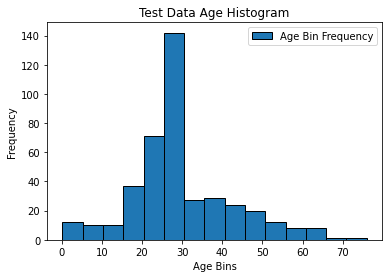

In [47]:
# plot the "Age" histogram.
plt.hist(test_data["Age"],
         bins=15,
         edgecolor="black",
         label="Age Bin Frequency")
plt.title("Test Data Age Histogram")
plt.xlabel("Age Bins")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

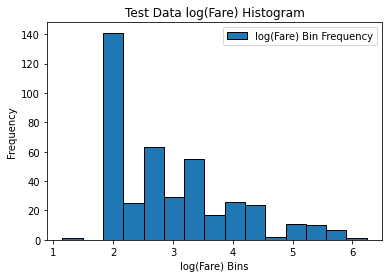

In [48]:
# plot the "log(Fare)" histogram.
plt.hist(test_data["log(Fare)"],
         bins=15,
         edgecolor="black",
         label="log(Fare) Bin Frequency")
plt.title("Test Data log(Fare) Histogram")
plt.xlabel("log(Fare) Bins")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

At this point, after reviewing the data sets once more, it has
occurred to us that we should remove any redundant fields from
the data as well. Specifically, we should remove the "Name" field
from both data sets as it is just a textual version of the
"PassengerId" field. We can simply represent an individual
passenger by their ID.

In [49]:
# drop the "Name" field from both data sets.
train_data.drop(columns="Name", inplace=True)
test_data.drop(columns="Name", inplace=True)

In [50]:
# use the head() function to check the training data.
train_data.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Dletter,log(Fare)
0,1,0,3,male,22.0,1,0,S,NaN,1.981001
1,2,1,1,female,38.0,1,0,C,C,4.266662
2,3,1,3,female,26.0,0,0,S,NaN,2.070022
3,4,1,1,female,35.0,1,0,S,C,3.972177
4,5,0,3,male,35.0,0,0,S,NaN,2.085672


In [51]:
# use the head() function to check the test data.
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,Dletter,log(Fare)
0,892,3,male,34.5,0,0,Q,NaN,2.057860
1,893,3,female,47.0,1,0,S,NaN,1.945910
2,894,2,male,62.0,0,0,Q,NaN,2.270836
3,895,3,male,27.0,0,0,S,NaN,2.159003
4,896,3,female,22.0,1,1,S,NaN,2.508582


We should also convert the text-based categorical data fields
into numeric data fields by assigning specific numbers to each
possible text entry in the respective fields.

Let's start with the "Sex" field.

In [52]:
# Determine how many unique entries exist in the "Sex" field
# for both data sets.
print(f"Training Data Unique Sex Field Entries: {len(train_data.groupby('Sex'))}")
print(f"Test Data Unique Sex Field Entries: {len(test_data.groupby('Sex'))}")

Training Data Unique Sex Field Entries: 2
Test Data Unique Sex Field Entries: 2


In [53]:
# encode the "Sex" field in both data sets using a lambda function.
# 0 = male.
# 1 = female.
train_data["Sex"] = train_data["Sex"].apply(lambda entry : 0 if (str(entry) == "male")
                                            else 1)
test_data["Sex"] = test_data["Sex"].apply(lambda entry : 0 if (str(entry) == "male")
                                          else 1)

Now, let us encode the "Dletter" data by how deep the deck is in the ship,
relative to the top surface.

In [54]:
# Determine how many unique entries exist in the "Dletter" field
# for both data sets.
print(f"Training Data Unique Dletter Field Entries: {len(train_data.groupby('Dletter'))}")
print(f"Test Data Unique Dletter Field Entries: {len(test_data.groupby('Dletter'))}")

Training Data Unique Dletter Field Entries: 9
Test Data Unique Dletter Field Entries: 8


In [55]:
# Determine which "Dletter" values exist in the training data.
train_data.groupby("Dletter")["PassengerId"].count()

Dletter
A       14
B       43
C       59
D       33
E       32
F        9
G        4
NaN    675
T        1
Name: PassengerId, dtype: int64

In [56]:
#Determine which "Dletter" values exist in the test data.
test_data.groupby("Dletter")["PassengerId"].count()

Dletter
A        7
B       17
C       35
D       13
E        9
F        5
G        1
NaN    325
Name: PassengerId, dtype: int64

Upon reviewing the unique values contained in the "Dletter" fields
for both data sets, it appears that the test data doesn't contain
any passengers who owned cabins on the T deck, while the training
data only contaisn one such passenger record.

After a quick Internet search about the possible reasons for these
observations, we rediscovered the previously mentioned webpage
(URL https://www.encyclopedia-titanica.org/cabins.html ). Based on
information in this webpage, it seems that there is evidence of
only one passenger boarding in a cabin on the "Boat Deck," denoted
in the "Dletter" field as "T". Thus, to prevent this outlier from
potentially damaging the performance of our future models, it should
be removed from the training data.

In [57]:
print(f"Initial Training Data Length: {len(train_data)}")
train_data = train_data[train_data["Dletter"] != "T"]
print(f"New Training Data Length: {len(train_data)}")

Initial Training Data Length: 870
New Training Data Length: 869


Now, we can proceed with the encoding of the "Dletter" field in
each of the data sets.

In [58]:
# define a function to encode the "Dletter" field entries.
def encode_dletter(entry):
    if str(entry) == "A":
        return 0
    elif str(entry) == "B":
        return 1
    elif str(entry) == "C":
        return 2
    elif str(entry) == "D":
        return 3
    elif str(entry) == "E":
        return 4
    elif str(entry) == "F":
        return 5
    elif str(entry) == "G":
        return 6
    else:
        return 7

In [59]:
# use the previously defined function to encode the "Dletter" fields
# in both data sets.
train_data["Dletter"] = train_data["Dletter"].apply(lambda entry : encode_dletter(entry))
test_data["Dletter"] = test_data["Dletter"].apply(lambda entry : encode_dletter(entry))

Finally, we should encode the "Embarked" data field. Although at first glance
there doesn't seem to be a very meaningful method in which this field should be
encoded, a brief Internet search helped us determine what we should do. According
to an article from ThoughtCo (found at URL https://www.thoughtco.com/titanic-timeline-1779210 ),
the Titanic first embarked from Southampton, England, then from Cherbourg, France,
and finally from Queenstown, Ireland (known today as Cobh, Ireland, from Charles's
own personal knowledge from a family trip to Ireland). Therefore,
we can encode the "Embarked" data based on the order in which the Titanic
visited each port before its sinking.

In [60]:
# define a function to encode the "Embarked" data field entries.
def encode_embarked(entry):
    if str(entry) == "S":
        return 0
    elif str(entry) == "C":
        return 1
    else:
        return 2

In [61]:
# Use a lambda function to apply our previously defined function.
train_data["Embarked"] = train_data["Embarked"].apply(lambda entry : encode_embarked(entry))
test_data["Embarked"] = test_data["Embarked"].apply(lambda entry : encode_embarked(entry))

Now that everything has been encoded, let's try to print our updated
data sets to make sure our encoding of the non-numeric categorical fields
was successful.

In [62]:
# use the head(25) function on the training data.
train_data.head(25)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Dletter,log(Fare)
0,1,0,3,0,22.000000,1,0,0,7,1.981001
1,2,1,1,1,38.000000,1,0,1,2,4.266662
2,3,1,3,1,26.000000,0,0,0,7,2.070022
3,4,1,1,1,35.000000,1,0,0,2,3.972177
4,5,0,3,0,35.000000,0,0,0,7,2.085672
5,6,0,3,0,29.642093,0,0,2,7,2.135148
6,7,0,1,0,54.000000,0,0,0,4,3.948596
7,8,0,3,0,2.000000,3,1,0,7,3.048088
8,9,1,3,1,27.000000,0,2,0,7,2.409941
9,10,1,2,1,14.000000,1,0,1,7,3.403555


In [63]:
# use the head(25) function on the test data.
test_data.head(25)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,Dletter,log(Fare)
0,892,3,0,34.500000,0,0,2,7,2.057860
1,893,3,1,47.000000,1,0,0,7,1.945910
2,894,2,0,62.000000,0,0,2,7,2.270836
3,895,3,0,27.000000,0,0,0,7,2.159003
4,896,3,1,22.000000,1,1,0,7,2.508582
5,897,3,0,14.000000,0,0,0,7,2.221917
6,898,3,1,30.000000,0,0,2,7,2.031983
7,899,2,0,26.000000,1,1,0,7,3.367296
8,900,3,1,18.000000,0,0,1,7,1.978128
9,901,3,0,21.000000,2,0,0,7,3.184284


At this point, we can start our exploration of the data.

First, let's try and see if there is a relationship between
a passenger's survival and their socio-economic status. We can
do this multiple ways, so let's start with a boxplot with the
"Survived" data on the x-axis and the "log(Fare)" data on the
y-axis (using the training data).

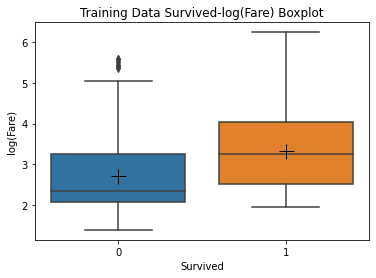

In [64]:
sb.boxplot(data=train_data,
           x="Survived",
           y="log(Fare)",
           showmeans=True,
           meanprops={
               "marker" : "+",
               "markeredgecolor" : "black",
               "markersize" : "15"
           })
plt.title("Training Data Survived-log(Fare) Boxplot")
plt.savefig("figure_one_log_fare_boxplot.png")

It appears that there is indeed a relationship between survival and
the logarithm of the fare paid for a ticket. Specifically, the mean
value of log(Fare) paid by those who perished in the sinking of the Titanic
is comparatively lower than the mean value of log(Fare) paid by those
who survived the tragedy. Let us test this with a T-test using Welch's
t-statistic.

First, we need to create separate DataFrame objects to contain records of
those who survived and those who did not.

In [65]:
temp = train_data[train_data["Survived"] == 0]
perished_log_fare_data = temp["log(Fare)"]

temp = train_data[train_data["Survived"] == 1]
survived_log_fare_data = temp["log(Fare)"]

Now we can perform the T-test on these two data sets.

In [66]:
stats.ttest_ind(perished_log_fare_data,
                survived_log_fare_data,
                equal_var=False)

Ttest_indResult(statistic=-9.51007150892796, pvalue=4.518482891058762e-20)

Based on this T-test using Welch's t-statistic, we have determined that
the difference between the mean log(Fare) values paid by those who survived
and those who perished has a p-value of approximately 4.5185 E-20. Because
the aforementioned p-value is less than the alpha = 0.05 level of significance,
we are justified in saying that the difference between the mean values of
log(Fare) paid by those who survived and those who didn't is statistically
significant. Therefore, between this T-test and the previously created boxplot,
it seems likely that the relationship between the log(Fare) paid by a passenger
and said passenger's survival during the Titanic's sinking is described as
being a positive correlation: the higher the value of log(Fare), the more likely
the passenger was to survive. Because people in lower socio-economic classes
couldn't pay for the more expensive tickets, it is implied that passengers that
fell under this label were more likely to perish.

Let's try to figure out a relationship between survival and age. This can
be done in a way similar to how we established a relationship between
survival and the logarithm of the paid fare.

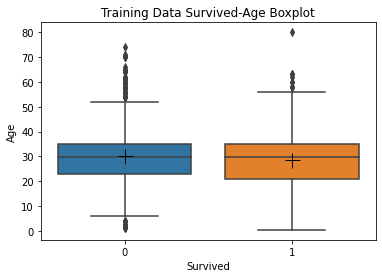

In [67]:
sb.boxplot(data=train_data,
           x="Survived",
           y="Age",
           showmeans=True,
           meanprops={
               "marker" : "+",
               "markeredgecolor" : "black",
               "markersize" : "15"
           })
plt.title("Training Data Survived-Age Boxplot")
plt.savefig("figure_two_survived_age_boxplot.png")

Surprisingly, it seems that the mean age of the survivors is similar
to the mean age of those who didn't. This might mean that there is not
a strong relationship between age and chances of survival. However,
let us perform another T-test using Welch's t-statistic just
to be certain that our observation holds true.

First, we need to separate age data for those who survived from the
age data for those who didn't.

In [68]:
temp = train_data[train_data["Survived"] == 0]
perished_age_data = temp["Age"]

temp = train_data[train_data["Survived"] == 1]
survived_age_data = temp["Age"]

Now we can perform our T-test.

In [69]:
stats.ttest_ind(perished_age_data,
                survived_age_data,
                equal_var=False)

Ttest_indResult(statistic=2.0570526981810007, pvalue=0.040066801118590095)

Yet another surprise - at least to us - is that our most recent T-test
showed that the difference between the mean ages of those who survived
and those who didn't is, in fact, significant at an alpha = 0.05 level
of significance, as the p-value of approximately 0.0401 is less than 0.05.
However, the p-value from this T-test is much larger than that of our previous
T-test between the mean logarithms of fare paid by those who survived and
those who didn't. The difference in mean logarithms of fare paid by those
who survived and those who didn't was significant not only at the alpha = 0.05
level of significance, but also at the alpha = 0.01 level of significance.
The difference in mean ages of those who survived and those who didn't, however,
is barely significant at the alpha = 0.05 level of significance, and it is not
significant at the alpha = 0.01 level of significance. This means that while
there does exist a relationship between age and chance of survival, it doesn't
seem to be as concrete as the relationship between the logarithm of fare
and chance of survival.

We can check these previous two observations by calculating the
pairwise Pearson correlation coefficients between the "Survived,"
"log(Fare)," and "Age" fields in the data; we can also include the
other numerical fields - "SibSp" and "Parch" - for completeness.

In [70]:
# create numeric data set and calculate pairwise Pearson correlations.
pearson_numeric = train_data[["Survived", "Age", "log(Fare)", "SibSp", "Parch"]]
pearson_correlation = pearson_numeric.corr(method="pearson")

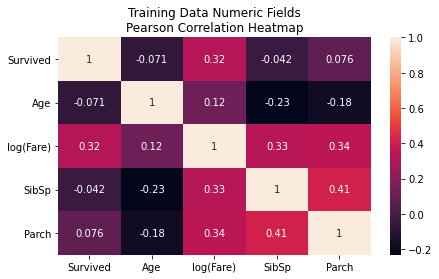

In [71]:
# plot heatmap.
plt.figure(figsize=(7,4))
sb.heatmap(pearson_correlation, annot=True)
plt.title("Training Data Numeric Fields\nPearson Correlation Heatmap")
plt.savefig("figure_three_numeric_heatmap.png")

The pairwise Pearson correlation coefficient heatmap that we just created
indicates that we were correct in our (updated) prediction that the
relationship between "Age" and "Survived" is not very strong - the effect size
is most likely negligible, as "small" effect sizes are generally considered
to have absolute value of Pearson correlation coefficient of at least 0.20. Therefore,
even though the relationship between "Age" and "Survived" was determined to be
significant by our T-test, the actual magnitude of the relationship is extremely
small, as determined by the Pearson correlation coefficient between them.

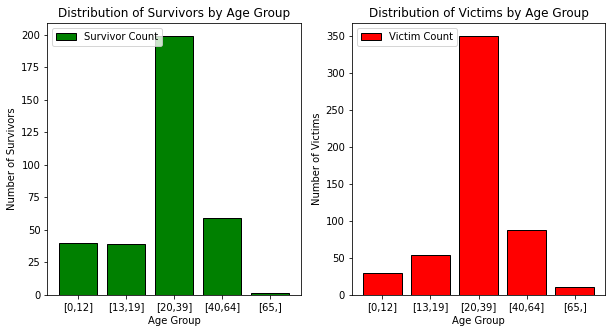

In [72]:
child_age = train_data.loc[(train_data["Age"] > 0) & (train_data["Age"] <= 12) & (train_data['Survived'] == 1), "Survived"]
teen_age = train_data.loc[(train_data["Age"] > 12) & (train_data["Age"] <= 19) & (train_data['Survived'] == 1), "Survived"]
young_adult_age = train_data.loc[(train_data["Age"] > 19) & (train_data["Age"] <= 39) & (train_data['Survived'] == 1), "Survived"]
middle_age = train_data.loc[(train_data["Age"] > 39) & (train_data["Age"] <= 64) & (train_data['Survived'] == 1), "Survived"]
senior_age = train_data.loc[(train_data["Age"] > 64) & (train_data['Survived'] == 1), "Survived"]

x_axis = ["[0,12]", "[13,19]", "[20,39]", "[40,64]", "[65,]"]
y_axis = [len(child_age), len(teen_age), len(young_adult_age), len(middle_age), len(senior_age)]

figure_temp = plt.figure(figsize=(10, 5))

ax_one = figure_temp.add_subplot(121)
ax_one.bar(x_axis, y_axis,
           color="green",
           edgecolor="black",
           label="Survivor Count")
plt.title("Distribution of Survivors by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Survivors")
plt.legend(loc="upper left")

child_age = train_data.loc[(train_data["Age"] > 0) & (train_data["Age"] <= 12) & (train_data['Survived'] == 0), "Survived"]
teen_age = train_data.loc[(train_data["Age"] > 12) & (train_data["Age"] <= 19) & (train_data['Survived'] == 0), "Survived"]
young_adult_age = train_data.loc[(train_data["Age"] > 19) & (train_data["Age"] <= 39) & (train_data['Survived'] == 0), "Survived"]
middle_age = train_data.loc[(train_data["Age"] > 39) & (train_data["Age"] <= 64) & (train_data['Survived'] == 0), "Survived"]
senior_age = train_data.loc[(train_data["Age"] > 64) & (train_data['Survived'] == 0), "Survived"]

x_axis = ["[0,12]", "[13,19]", "[20,39]", "[40,64]", "[65,]"]
y_axis = [len(child_age), len(teen_age), len(young_adult_age), len(middle_age), len(senior_age)]

ax_two = figure_temp.add_subplot(122)
ax_two.bar(x_axis, y_axis,
           color="red",
           edgecolor="black",
           label="Victim Count")
plt.title("Distribution of Victims by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Victims")
plt.legend(loc="upper left")

plt.savefig("figure_four_age_survivor_distribution_bar.png")

The relationship between "Survived" and "log(Fare)," however, is significant and
also is considered a "small" effect size, as the absolute value of the
Pearson correlation coefficient between them is greater than 0.20 (the conventional
lower bound for relationships of "small" effect size). This implies that we were
correct in our statement that people of higher socio-economic class (determined
using logarithm of fare as an indicative proxy) had a greater chance of surviving.

Another relationship that might be useful in exploring the importance of
socio-economic class is the relationship between "log(Fare)" and "SibSp".
This relationship is of a "small" effect size, as the pairwise
Pearson correlation coefficient between them is greater than 0.20. The logic behind
this observation seems to make sense: passengers who were bringing family
members - siblings, spouses - with them had to pay for more space on the ship.
Bringing family along for the trip aboard the Titanic would be much more expensive
than buying a single ticket for oneself, so the "log(Fare)" field is
only reflecting the common economic model of "pay per item": the more tickets
a passenger bought, the higher the fare they would have to pay. At this point, we
cannot make a statement about how this relates to socio-economic clas using only the
data we have so far. However, we can explore the socio-economic implications further
through more analysis.

Percentage of First Class passengers with siblings/spouse on board: 37.98%
Percentage of Second Class passengers with siblings/spouse on board: 35.96%
Percentage of Third Class passengers with siblings/spouse on board: 28.78%


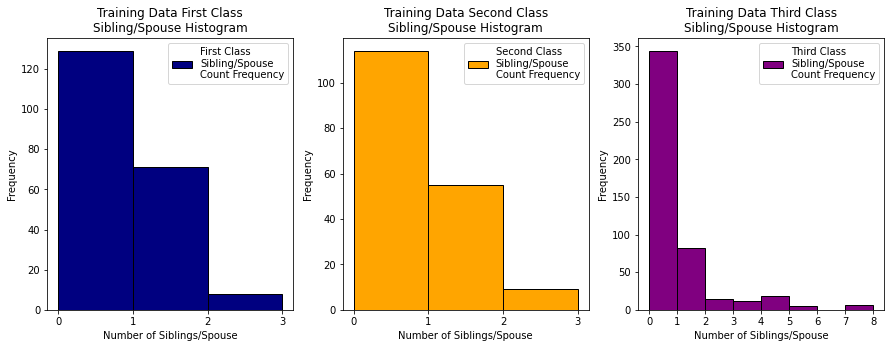

In [73]:
# create matplotlib figure space.
figure_temp = plt.figure(figsize=(15, 5))

# plot first-class sibling/spouse count histogram.
ax_one = figure_temp.add_subplot(131)

first_class_data = train_data[train_data["Pclass"] == 1]
ax_one.hist(first_class_data["SibSp"],
            bins=3,
            edgecolor="black",
            color="navy",
            label="First Class\nSibling/Spouse\nCount Frequency")
plt.title("Training Data First Class\nSibling/Spouse Histogram")
plt.xlabel("Number of Siblings/Spouse")
plt.ylabel("Frequency")
plt.xticks([0, 1, 2, 3])
plt.legend(loc="upper right")

# print percentage of first-class passengers with non-zero "SibSp" entries.
print("Percentage of First Class passengers with siblings/spouse on board: " +
      "{:.2%}".format(len(first_class_data[first_class_data["SibSp"] > 0]) / len(first_class_data)))

# plot second-class sibling/spouse count histogram.
ax_two = figure_temp.add_subplot(132)

second_class_data = train_data[train_data["Pclass"] == 2]
ax_two.hist(second_class_data["SibSp"],
            bins=3,
            edgecolor="black",
            color="orange",
            label="Second Class\nSibling/Spouse\nCount Frequency")
plt.title("Training Data Second Class\nSibling/Spouse Histogram")
plt.xlabel("Number of Siblings/Spouse")
plt.ylabel("Frequency")
plt.xticks([0, 1, 2, 3])
plt.legend(loc="upper right")

# print percentage of second-class passengers with non-zero "SibSp" entries.
print("Percentage of Second Class passengers with siblings/spouse on board: " +
      "{:.2%}".format(len(second_class_data[second_class_data["SibSp"] > 0]) / len(second_class_data)))

# plot third-class sibling/spouse count histogram.
ax_three = figure_temp.add_subplot(133)

third_class_data = train_data[train_data["Pclass"] == 3]
ax_three.hist(third_class_data["SibSp"],
              bins=8,
              edgecolor="black",
              color="purple",
              label="Third Class\nSibling/Spouse\nCount Frequency")
plt.title("Training Data Third Class\nSibling/Spouse Histogram")
plt.xlabel("Number of Siblings/Spouse")
plt.ylabel("Frequency")
plt.xticks(range(0, 9))
plt.legend(loc="upper right")

# print percentage of third-class passengers with non-zero "SibSp" entries.
print("Percentage of Third Class passengers with siblings/spouse on board: " +
      "{:.2%}".format(len(third_class_data[third_class_data["SibSp"] > 0]) / len(third_class_data)))

plt.savefig("figure_five_sibsp_dist_by_class.png")

Based on these histograms and their associated percentages of
non-zero "SibSp" entries, it has been shown that the ticket class
with the largest proportion of non-zero "SibSp" entries (passengers
who had at least one sibling/spouse relatives on board the Titanic)
was the first class, with the second class close behind and the third
class far behind both the first and second classes. Thus, the relationship
between socio-economic class (using ticket class as a proxy) and the
number of siblings/spouse a passenger brought with them on the Titanic
has been proven: the conditional probability that a passenger brought
their sibling(s)/spouse with them on the titanic given their ticket class
class increases as one looks up the soio-economic hierarchy. In other words,
passengers in higher socio-economic class were more likely to bring their
sibling(s)/spouse with them on the Titanic.

The last relationship in this heatmap that might be useful in evaluating
the importance of socio-economic class on the Titanic is between the
"log(Fare)" and "Parch" data fields. The pairwise Pearson correlation
coefficient between "log(Fare)" and "Parch" is also greater than 0.20, meaning
that the associated relationship is of "small" effect size. This observation
is supported by similar reasoning that was used to support the relationship
between socio-economic status and the number of sibling(s)/spouse a passenger
brough with them: a passenger would have to pay for additional tickets in order
to bring their children/parents with them on the Titanic, thus making the fare
they'd have to pay (and inherently the logarithm of their paid fare) greater.
Remembering the value of money was much higher in 1912 than it is today, such
high fares we usually only affordable by those with more money, and therefore,
those of high socio-economic classes. We can show this again using histograms.

Percentage of First Class passengers with parents/childen on board: 25.48%
Percentage of Second Class passengers with parents/children on board: 28.09%
Percentage of Third Class passengers with parents/children on board: 22.57%


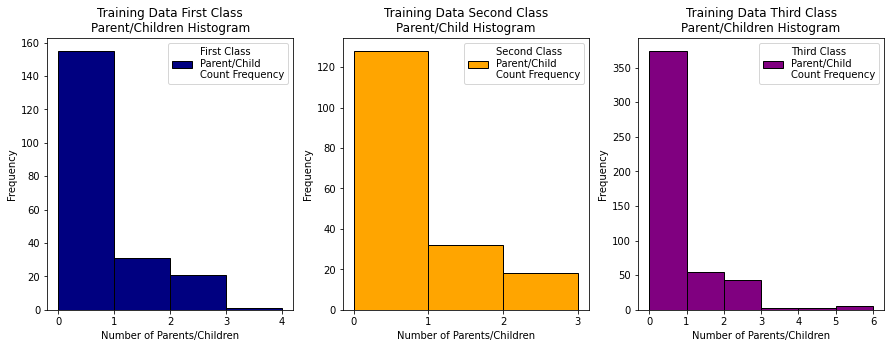

In [74]:
# create matplotlib figure space.
figure_temp = plt.figure(figsize=(15, 5))

# plot first-class parents/children count histogram.
ax_one = figure_temp.add_subplot(131)
ax_one.hist(first_class_data["Parch"],
            bins=4,
            edgecolor="black",
            color="navy",
            label="First Class\nParent/Child\nCount Frequency")
plt.title("Training Data First Class\nParent/Children Histogram")
plt.xlabel("Number of Parents/Children")
plt.ylabel("Frequency")
plt.xticks([0, 1, 2, 3, 4])
plt.legend(loc="upper right")

# print percentage of first-class passengers with non-zero "Parch" entries.
print("Percentage of First Class passengers with parents/childen on board: " +
      "{:.2%}".format(len(first_class_data[first_class_data["Parch"] > 0]) / len(first_class_data)))

# plot second-class parents/children count histogram.
ax_two = figure_temp.add_subplot(132)
ax_two.hist(second_class_data["Parch"],
            bins=3,
            edgecolor="black",
            color="orange",
            label="Second Class\nParent/Child\nCount Frequency")
plt.title("Training Data Second Class\nParent/Child Histogram")
plt.xlabel("Number of Parents/Children")
plt.ylabel("Frequency")
plt.xticks([0, 1, 2, 3])
plt.legend(loc="upper right")

# print percentage of second-class passengers with non-zero "Parch" entries.
print("Percentage of Second Class passengers with parents/children on board: " +
      "{:.2%}".format(len(second_class_data[second_class_data["Parch"] > 0]) / len(second_class_data)))

# print third-class parents/children count histogram.
ax_three = figure_temp.add_subplot(133)
ax_three.hist(third_class_data["Parch"],
              bins=6,
              edgecolor="black",
              color="purple",
              label="Third Class\nParent/Child\nCount Frequency")
plt.title("Training Data Third Class\nParent/Children Histogram")
plt.xlabel("Number of Parents/Children")
plt.ylabel("Frequency")
plt.xticks(range(0, 7))
plt.legend(loc="upper right")

# print percentage of third-class passengers with non-zero "Parch" entries.
print("Percentage of Third Class passengers with parents/children on board: " +
      "{:.2%}".format(len(third_class_data[third_class_data["Parch"] > 0]) / len(third_class_data)))

plt.savefig("figure_six_parch_dist_by_class.png")

Surprisingly, our histograms show that the conditional probability
that a passenger brings parent(s)/child(ren) with them on the titanic is
highest if said passenger is in second class. While this was unexpected, there
is one possible logical explanation: quantity increases price. What this refers
to is the fact that buying multiple first class tickets costs much more
than buying multiple second class tickets. Thus, some passengers who were
considered to be in the upper middle and lower upper classes might have chosen
to forgo usually affordable first class tickets in favor of less expensive second
class tickets in the event that they needed to bring their parent(s)/child(ren) with
them. While there is no way for us to prove this directly using our current data, this
would certainly be an interesting theory to try and prove in the future using
different data. Nonetheless, while our prediction that passengers of higher
socio-economic status were more likely to bring parent(s)/child(ren) with them
is not entirely as direct as we had hoped, there is still a relationship: second class
tickets still cost more than third class tickets, and once again, the probability that
a passenger bring their parent(s)/child(ren) with them given their socio-economic
status was lowest for passengers with third class tickets. Thus, the statement that
those who were of the lowest socio-economic classes generally couldn't afford to bring
parent(s)/child(ren) with them is supported by comparison to the second and third class
data.

Although the "Parch" and "SibSp" fields were part of different relationships
that were useful for analyzing the importance of socio-economic status on the
Titanic, they don't seem to have very meaningful relationships with the "Survived"
field of the data. The correlations between both of these fields and the "Survived"
field are less than the minimum strength required for a "small" effect size. Thus,
we can predict that these data features will not be very useful in predicting whether
a passenger has survived or not.

Now, let us try to determine if there is relationship between survival and
some categorical data fields in our data: "Pclass," Sex," "Embarked," and
"Dletter". We can first attempt calculating the pairwise Pearson correlation
coefficients for each possible pair of categorical data fields.

In [75]:
# create categorical data set and calculate pairwise Pearson correlations.
pearson_categorical = train_data[["Survived", "Pclass", "Sex", "Embarked", "Dletter"]]
pearson_correlation = pearson_categorical.corr(method="pearson")

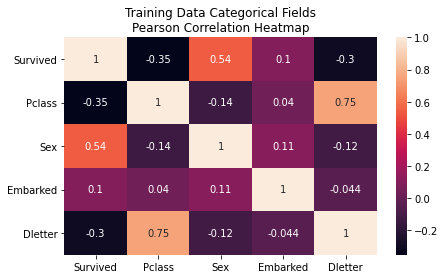

In [76]:
# plot heatmap.
plt.figure(figsize=(7, 4))
sb.heatmap(pearson_correlation, annot=True)
plt.title("Training Data Categorical Fields\nPearson Correlation Heatmap")

plt.savefig("figure_seven_categorical_heatmap.png")

It appears that of the categorical fields, the "Sex," "Dletter," and "Pclass"
fields have the highest correlation with the "Survived" field. However,
these values may be somewhat misleading. For instance, both the "Sex" and
"Survived" fields have only two possible values: 0 and 1. Therefore,
it is much more likely that these two fields will show higher correlations
with each other because patterns and trends appear much more commonly
between data fields whose entries draw their values from a small range of
discrete numbers. The fact that both data fields are discrete is already a
potential issue when using Pearson correlation coefficient, but layering on
top of this the facts that both fields only have two possible values and that
these possible values come from the same range of values might only be making
these calculations all the less meaningful.

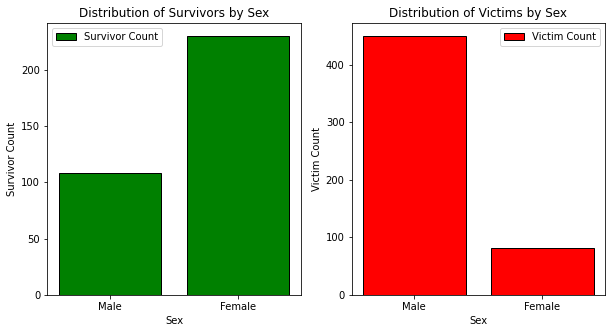

In [77]:
males = train_data.loc[(train_data['Survived'] == 1) & (train_data['Sex'] == 0), "Survived"]
females = train_data.loc[(train_data['Survived'] == 1) & (train_data['Sex'] == 1), "Survived"]

x_axis = ["Male", "Female"]
y_axis = [len(males), len(females)]

figure_temp = plt.figure(figsize=(10, 5))

ax_one = figure_temp.add_subplot(121)
ax_one.bar(x_axis, y_axis,
           color="green",
           edgecolor="black",
           label="Survivor Count")
plt.title("Distribution of Survivors by Sex")
plt.xlabel("Sex")
plt.ylabel("Survivor Count")
plt.legend(loc="upper left")

males = train_data.loc[(train_data['Survived'] == 0) & (train_data['Sex'] == 0), "Survived"]
females = train_data.loc[(train_data['Survived'] == 0) & (train_data['Sex'] == 1), "Survived"]

x_axis = ["Male", "Female"]
y_axis = [len(males), len(females)]

ax_two = figure_temp.add_subplot(122)
ax_two.bar(x_axis, y_axis,
           color="red",
           edgecolor="black",
           label="Victim Count")
plt.title("Distribution of Victims by Sex")
plt.xlabel("Sex")
plt.ylabel("Victim Count")
plt.legend(loc="upper right")

plt.savefig("figure_eight_survival_sex_dist.png")

Similarly, the "Dletter" and "Survived" fields are both discrete. The difference
here, though, is that the "Dletter" field has a comparatively larger set of values
its entries can assume. Even though the data is more spread in this comparison between
"Survived" and "Dletter," it too, is most likely misleading. Indeed, the
gross lack of data about which passengers were assigned to which cabins on the
Titanic means that the "Dletter" field has many entries with default "NaN" values,
indicating an initial lack of information about where the associated passenger
was boarding on the ship. Let's analyze this further using bar graphs.

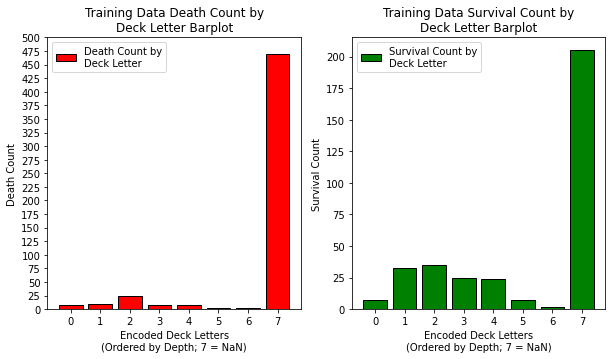

In [78]:
# create matplotlib figure space.
figure_temp = plt.figure(figsize=(10, 5))

# plot the death count data by deck letter.
temp = train_data[train_data["Survived"] == 0]
temp = temp.groupby("Dletter")["Survived"].count()
temp = temp.reset_index()

ax_one = figure_temp.add_subplot(121)
ax_one.bar(x=temp["Dletter"],
           height=temp["Survived"],
           label="Death Count by\nDeck Letter",
           edgecolor="black",
           color="red")
plt.title("Training Data Death Count by\nDeck Letter Barplot")
plt.legend(loc="upper left")
plt.xlabel("Encoded Deck Letters\n(Ordered by Depth; 7 = NaN)")
plt.ylabel("Death Count")
plt.yticks(range(0, 525, 25))
plt.xticks(range(0, 8))

# plot the survival count by deck letter.
temp = train_data[train_data["Survived"] == 1]
temp = temp.groupby("Dletter")["Survived"].count()
temp = temp.reset_index()

ax_two = figure_temp.add_subplot(122)
ax_two.bar(x=temp["Dletter"],
           height=temp["Survived"],
           label="Survival Count by\nDeck Letter",
           edgecolor="black",
           color="green")
plt.title("Training Data Survival Count by\nDeck Letter Barplot")
plt.legend(loc="upper left")
plt.xlabel("Encoded Deck Letters\n(Ordered by Depth; 7 = NaN)")
plt.ylabel("Survival Count")
plt.yticks(range(0, 225, 25))
plt.xticks(range(0, 8))

plt.savefig("figure_nine_survival_dletter_dist.png")

The majority of passenger records in the data set have the "NaN" placeholder
string in their "Dletter" field. This follows from what we knew about the original
"Cabin" field that came with the data set: because the majority of the records
were missing entries in the "Cabin" field, these same records will be given the
"NaN" placeholder string so the data can still be used. Thus, we should try to see what
we get when we don't include "NaN" placeholder string entries.

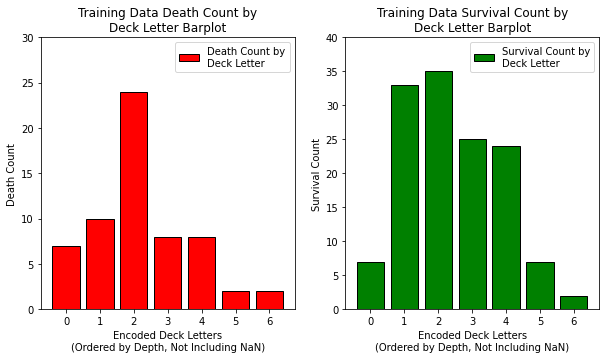

In [79]:
# create matplotlib figure space.
figure_temp = plt.figure(figsize=(10, 5))

# plot the death count data by deck letter.
temp = train_data[train_data["Survived"] == 0]
temp = temp[temp["Dletter"] != 7]
temp = temp.groupby("Dletter")["Survived"].count()
temp = temp.reset_index()

ax_one = figure_temp.add_subplot(121)
ax_one.bar(x=temp["Dletter"],
           height=temp["Survived"],
           label="Death Count by\nDeck Letter",
           edgecolor="black",
           color="red")
plt.title("Training Data Death Count by\nDeck Letter Barplot")
plt.legend(loc="upper right")
plt.xlabel("Encoded Deck Letters\n(Ordered by Depth, Not Including NaN)")
plt.ylabel("Death Count")
plt.yticks(range(0, 35, 5))
plt.xticks(range(0, 7))

# plot the survival count by deck letter.
temp = train_data[train_data["Survived"] == 1]
temp = temp[temp["Dletter"] != 7]
temp = temp.groupby("Dletter")["Survived"].count()
temp = temp.reset_index()

ax_two = figure_temp.add_subplot(122)
ax_two.bar(x=temp["Dletter"],
           height=temp["Survived"],
           label="Survival Count by\nDeck Letter",
           edgecolor="black",
           color="green")
plt.title("Training Data Survival Count by\nDeck Letter Barplot")
plt.legend(loc="upper right")
plt.xlabel("Encoded Deck Letters\n(Ordered by Depth, Not Including NaN)")
plt.ylabel("Survival Count")
plt.yticks(range(0, 45, 5))
plt.xticks(range(0, 7))

plt.savefig("figure_ten_updated_survival_dletter_dist.png")

These updated bar plots seem to indicate that more passengers who
were residing in cabins on the middle decks of the ship survived than
those in the far upper and far lower decks. Specifically, of the records
without "NaN" placeholder strings in their "Dletter" fields, more passengers
on decks B, C, D, and E survived (the respective encodings of these decks, in
order, are 1, 2, 3, and 4). Based on the data we have, it would be
difficult to formulate any concrete reasons for this observation. However,
one can speculate that these decks might have been supplied with a larger
number of lifeboats. Regardless, by comparing the two sets of
histograms, it is somewhat apparent that the reason for the strong correlation
between the "Survived" and "Dletter" fields is the overwhelming quantity
of records containing the "NaN" placeholder string. Because the number
of "NaN" placeholder string "Dletter" records is much larger than the number
of records with actual deck letters in the "Dletter" field, it makes sense
that more people with "NaN" string placeholders in their "Dletter" fields would've
survived and died. Thus, there is an inherent correlation between the
"Dletter" and "Survived" fields: of the over 600 records with "NaN" placeholder
strings in their "Dletter" fields, the majority of the associated passengers died
in the tragedy, so a recognizably negative relationship between the "Survived" and
"Dletter" fields seems like a logical result. Because the correlation is most likely
artificial, then, it seems that the model would be better off if the "Dletter"
feature was not included.

A similar phenomena most likely explains the relatively strong relationship
between the "Pclass" and "Dletter," but let's analyze this before
we settle on this conclusion.

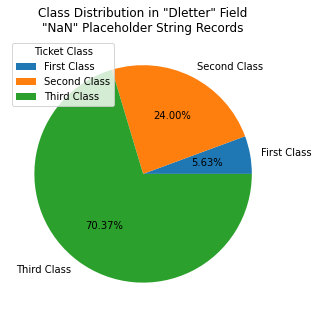

In [80]:
first_class_nan = train_data.loc[(train_data["Dletter"] == 7) & (train_data["Pclass"] == 1), "Survived"]
second_class_nan = train_data.loc[(train_data["Dletter"] == 7) & (train_data["Pclass"] == 2), "Survived"]
third_class_nan = train_data.loc[(train_data["Dletter"] == 7) & (train_data["Pclass"] == 3), "Survived"]

labels = ["First Class", "Second Class", "Third Class"]
lengths = [len(first_class_nan), len(second_class_nan), len(third_class_nan)]

plt.figure(figsize=(5, 5))
plt.pie(lengths, labels=labels, autopct="%.2f%%")
plt.title("Class Distribution in \"Dletter\" Field\n\"NaN\" Placeholder String Records")
plt.legend(loc="upper left", title="Ticket Class")

plt.savefig("figure_eleven_class_dist_dletter_nan.png")

Our prediction was most likely true, then: the majority of the records
with "NaN" placeholder strings in the "Dletter" field are associated with
passengers who owned third class tickets. Thus, the correlation between
"Pclass" and "Dletter" makes sense. The sheer number of such records, coupled
with the fact that a large majority of them are associated with passengers who
owned third class tickets, means that the correlation coefficient between the
two data features has the potential to be relatively large. This was, in fact,
the case with the correlation coefficient we observed.

Now, let us analyze the relationship between the "Survived" and "Embarked"
fields.

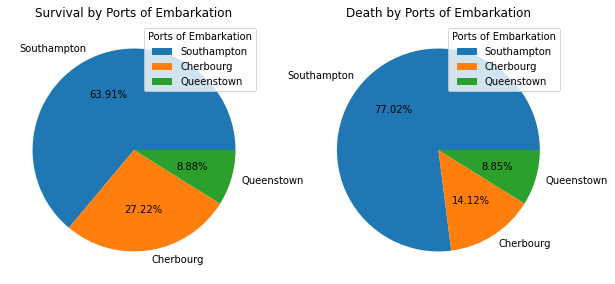

In [81]:
southampton = train_data.loc[(train_data["Embarked"] == 0) & (train_data["Survived"] == 1), "Embarked"]
cherbourg = train_data.loc[(train_data["Embarked"] == 1) & (train_data["Survived"] == 1), "Embarked"]
queenstown = train_data.loc[(train_data["Embarked"] == 2) & (train_data["Survived"] == 1), "Embarked"]

labels = ["Southampton", "Cherbourg", "Queenstown"]
lengths = [len(southampton), len(cherbourg), len(queenstown)]

figure_temp = plt.figure(figsize=(10, 5))

ax_one = figure_temp.add_subplot(121)
ax_one.pie(lengths, labels=labels, autopct="%.2f%%")
plt.title("Survival by Ports of Embarkation")
plt.legend(loc="upper right", title="Ports of Embarkation")

southampton = train_data.loc[(train_data["Embarked"] == 0) & (train_data["Survived"] == 0), "Embarked"]
cherbourg = train_data.loc[(train_data["Embarked"] == 1) & (train_data["Survived"] == 0), "Embarked"]
queenstown = train_data.loc[(train_data["Embarked"] == 2) & (train_data["Survived"] == 0), "Embarked"]

labels = ["Southampton", "Cherbourg", "Queenstown"]
lengths = [len(southampton), len(cherbourg), len(queenstown)]

ax_two = figure_temp.add_subplot(122)
ax_two.pie(lengths, labels=labels, autopct="%.2f%%")
plt.title("Death by Ports of Embarkation")
plt.legend(loc="upper right", title="Ports of Embarkation")

plt.savefig("figure_twelve_survival_embarkation_dist.png")

Based on these previous plots, it appears that the majority of survivors
embarked from Southampton, and the majority of victims also embarked from
Southampton. This makes sense as Southampton was the Titanic's port of
origin: it began its ill-fated journey there, and most of its passengers
boarded at this point.

Finally, let us explore the correlation between the "Pclass" and "Survived"
fields.

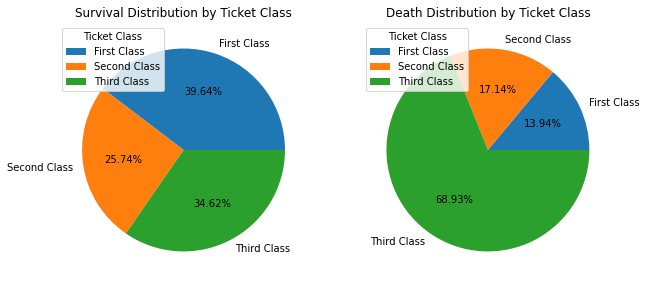

In [82]:
figure_temp = plt.figure(figsize=(10, 5))

first_class_survived = train_data.loc[(train_data["Pclass"] == 1) & (train_data["Survived"] == 1), "Pclass"]
second_class_survived = train_data.loc[(train_data["Pclass"] == 2) & (train_data["Survived"] == 1), "Pclass"]
third_class_survived = train_data.loc[(train_data["Pclass"] == 3) & (train_data["Survived"] == 1), "Pclass"]

labels = ["First Class", "Second Class", "Third Class"]
lengths = [len(first_class_survived), len(second_class_survived), len(third_class_survived)]

ax_one = figure_temp.add_subplot(121)
ax_one.pie(lengths, labels=labels, autopct="%.2f%%")
plt.title("Survival Distribution by Ticket Class")
plt.legend(loc="upper left", title="Ticket Class")

first_class_died = train_data.loc[(train_data["Pclass"] == 1) & (train_data["Survived"] == 0), "Pclass"]
second_class_died = train_data.loc[(train_data["Pclass"] == 2) & (train_data["Survived"] == 0), "Pclass"]
third_class_died = train_data.loc[(train_data["Pclass"] == 3) & (train_data["Survived"] == 0), "Pclass"]

labels = ["First Class", "Second Class", "Third Class"]
lengths = [len(first_class_died), len(second_class_died), len(third_class_died)]

ax_two = figure_temp.add_subplot(122)
ax_two.pie(lengths, labels=labels, autopct="%.2f%%")
plt.title("Death Distribution by Ticket Class")
plt.legend(loc="upper left", title="Ticket Class")

plt.savefig("figure_fourteen_survival_pclass_pies_dist.png")

It looks like the survivors of the Titanic tragedy are evenly distributed
among ticket classes, but the victims mostly owned third class tickets, while
first class ticket-owning victims were relatively rare. This seems like a direct
indication of the relationship between socio-economic class and chances or survival.

At this point, we have enough information to start modelling. Let us first create a
baseline model to be used in evaluating our models. In this baseline model, we
should use very few parameters: we will two of the more meaningful fields in the data,
one numeric, one categorical.

In [83]:
x_baseline = train_data[["log(Fare)", "Pclass"]]
y_baseline = train_data["Survived"]

x_baseline_train, x_baseline_test,\
y_baseline_train, y_baseline_test = train_test_split(x_baseline,
                                                     y_baseline,
                                                     test_size=0.3,
                                                     random_state=0)

In [84]:
baseline_log_reg = LogisticRegression()
baseline_log_reg.fit(x_baseline_train, y_baseline_train)
y_predict_baseline_log_reg = baseline_log_reg.predict(x_baseline_test)

In [85]:
def c_matrix(matrix):
    return pd.DataFrame(matrix, columns=["Predicted True", "Predicted False"], index=["Actual True", "Actual False"])

In [86]:
conf_matrix_baseline_log_reg = confusion_matrix(y_baseline_test,
                                                y_predict_baseline_log_reg,
                                                labels=[1, 0])
conf_matrix_baseline_log_reg = c_matrix(conf_matrix_baseline_log_reg)
conf_matrix_baseline_log_reg

,Predicted True,Predicted False
Actual True,41,57
Actual False,20,143


Acccording to our confusion matrix, the baseline logistic regression
model accurately predicted 41 true positives and 143 true negatives, but
it also predicted 57 false negatives and 20 false positives.

In [87]:
print(f"Accuracy: {accuracy_score(y_baseline_test, y_predict_baseline_log_reg)}")
print(f"Precision: {precision_score(y_baseline_test, y_predict_baseline_log_reg)}")
print(f"Recall: {recall_score(y_baseline_test, y_predict_baseline_log_reg)}")
print(f"F-Score: {f1_score(y_baseline_test, y_predict_baseline_log_reg)}")

Accuracy: 0.7049808429118773
Precision: 0.6721311475409836
Recall: 0.41836734693877553
F-Score: 0.5157232704402516


While the model has a relatively high accuracy, its precision is a bit lower
than the accuracy, and the recal is less than 0.50. The overall F-score was
approximately 0.5157, making it a mediocre model in general, but not
too shabby for a baseline model.

In [88]:
y_predict_baseline_log_reg_probability = baseline_log_reg.predict_proba(x_baseline_test)[::,1]
fpr, tpr, _ = roc_curve(y_baseline_test, y_predict_baseline_log_reg_probability)
auc_baseline_log_reg = roc_auc_score(y_baseline_test, y_predict_baseline_log_reg_probability)

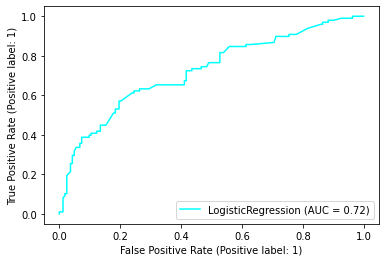

In [89]:
plot_roc_curve(baseline_log_reg, x_baseline_test, y_baseline_test,
               color="aqua")
plt.savefig("figure_fifteen_baseline_roc.png")

The ROC curve is somewhat close to the imaginary diagonal running from
(0.0, 0.0) to (1.0, 1.0). However, the area under the ROC Curve isn't
to bad.

Now let's try to create four more models that do a much better job than this baseline
model in predicting the survival or death of a given passenger on the Titanic.
We will use the more meaningful data features in our upcoming models: "Pclass,"
"Sex," "SibSp," and "log(Fare)." The models we will implement are logistic
regression, stochastic gradient descent classifier, decision tree, and k-nearest
neighbor.

First, let's split the entire training data set into a smaller training
data set and another data set that we can use to evaluate the performance
of our models.

In [90]:
x = train_data[["Pclass", "Sex", "SibSp", "log(Fare)"]]
y = train_data["Survived"]

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.3,
                                                    random_state=0)

x_cross, x_cross_two, y_cross, y_cross_two = train_test_split(x_train, y_train,
                                                      test_size=0.5,
                                                      random_state=0)

We can now start creating our models. Let's create a Logistic Regression
Model first. Logistic Regression is an application of Linear/Non-Linear
Regression to classification problems; instead of determining the algebraic
equation that best describes the relationship between two variables, it
determines the boundary line that best separates two distinct classes of data.
Logistic Regression is specifically used for binary classification problems:
problems which attempt to label data points with one of only two possible
classes.

In [91]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
y_predict_log_reg = log_reg.predict(x_test)

In [92]:
conf_matrix_log_reg = confusion_matrix(y_test,
                                       y_predict_log_reg,
                                       labels=[1, 0])
conf_matrix_log_reg = c_matrix(conf_matrix_log_reg)
conf_matrix_log_reg

,Predicted True,Predicted False
Actual True,73,25
Actual False,28,135


The confusion matrix for our linear regression model seems
to indicate a more accurate model than our baseline model: there
were 135 true negative predictions, 73 true positive predictions,
28 false positive predictions, and 25 false negative predictions.

In [93]:
print(f"Accuracy: {accuracy_score(y_test, y_predict_log_reg)}")
print(f"Precision: {precision_score(y_test, y_predict_log_reg)}")
print(f"Recall: {recall_score(y_test, y_predict_log_reg)}")
print(f"F-Score: {f1_score(y_test, y_predict_log_reg)}")

Accuracy: 0.7969348659003831
Precision: 0.7227722772277227
Recall: 0.7448979591836735
F-Score: 0.7336683417085428


The accuracy of this logistic regression model comparatively
higher than that of the baseline logistic regression model, as
are the precision and recall. The overall F-score is approximately
0.7337, a relatively good value.

In [94]:
y_predict_log_reg_probability = log_reg.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_log_reg_probability)
auc_log_reg = roc_auc_score(y_test, y_predict_log_reg_probability)

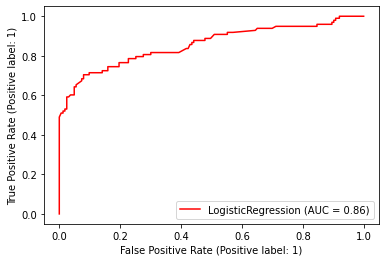

In [95]:
plot_roc_curve(log_reg, x_test, y_test,
               color="red")
plt.savefig("figure_sixteen_log_reg_roc.png")

The ROC Curve for this logistic regression model seems to be much
better than that of the baseline model because it is not as close to
the imaginary diagonal. Also, the area under the ROC Curve (AUC) is
comparatively better.

Next, let us try to use a Stochastic Gradient Descent (SGD) Classifier
to predict who would survive and who wouldn't. The Stochastic Gradient
Descent algorithm is one that is used to the trace a convex function
until the absolute minimum is found. Thus, the SGD Classifier is an
application of this algorithm to classification problems.

In [96]:
stoch_grad_desc = SGDClassifier(loss="modified_huber",
                                shuffle=True,
                                random_state=57)
stoch_grad_desc.fit(x_train, y_train)
y_predict_stoch_grad_desc = stoch_grad_desc.predict(x_test)

In [97]:
conf_matrix_stoch_grad_desc = confusion_matrix(y_test,
                                               y_predict_stoch_grad_desc,
                                               labels=[1, 0])
conf_matrix_stoch_grad_desc = c_matrix(conf_matrix_stoch_grad_desc)
conf_matrix_stoch_grad_desc

,Predicted True,Predicted False
Actual True,74,24
Actual False,37,126


The SGD classifier model has predicted 74 true positives, 126 true negatives,
24 false negatives, and 37 false positives.

In [98]:
print(f"Accuracy: {accuracy_score(y_test, y_predict_stoch_grad_desc)}")
print(f"Precision: {precision_score(y_test, y_predict_stoch_grad_desc)}")
print(f"Recall: {recall_score(y_test, y_predict_stoch_grad_desc)}")
print(f"F-Score: {f1_score(y_test, y_predict_stoch_grad_desc)}")

Accuracy: 0.7662835249042146
Precision: 0.6666666666666666
Recall: 0.7551020408163265
F-Score: 0.7081339712918658


The SGD Classifier's accuracy is a bit lower than that of our previous
logistic regression model (not the baseline), as is the precision. The
recall, however, is a little bit higher than our previous logistic regression
model's was (not the baseline). The overall F-score is approximately
0.7081. Thus, our best model so far is our logistic regression model
(not the baseline), using F-score as the main reference.

In [99]:
y_predict_stoch_grad_desc_probability = stoch_grad_desc.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_stoch_grad_desc_probability)
auc_stoch_grad_desc = roc_auc_score(y_test, y_predict_stoch_grad_desc_probability)

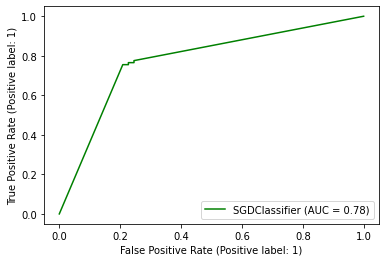

In [100]:
plot_roc_curve(stoch_grad_desc, x_test, y_test,
               color="green")
plt.savefig("figure_seventeen_stoch_grad_desc_roc.png")

The ROC Curve for the SGD classifier is not quite as good as that
of our logistic regression model (not the baseline), but it is still
better than that of the baseline. Furthermore, the AUC score of the
ROC Curve is also better than that of the baseline model, but worse
than that of the logistic regression model.

Now, let us try to create a Decision Tree model. A Decision Tree
is a tree-like algorithm that is used to make classification
decisions through the evaluation of a sequence of boolean comparisons
and expressions.

In [101]:
dec_tree = DecisionTreeClassifier(max_depth=10,
                                  random_state=78,
                                  max_features=None,
                                  min_samples_leaf=15)
dec_tree.fit(x_train, y_train)
y_predict_dec_tree = dec_tree.predict(x_test)

In [102]:
conf_matrix_dec_tree = confusion_matrix(y_test,
                                        y_predict_dec_tree,
                                        labels=[1, 0])
conf_matrix_dec_tree = c_matrix(conf_matrix_dec_tree)
conf_matrix_dec_tree

,Predicted True,Predicted False
Actual True,68,30
Actual False,18,145


The decision tree model has predicted 68 true positives, 145 true negatives,
30 false negatives, and 18 false positives.

In [103]:
print(f"Accuracy: {accuracy_score(y_test, y_predict_dec_tree)}")
print(f"Precision: {precision_score(y_test, y_predict_dec_tree)}")
print(f"Recall: {recall_score(y_test, y_predict_dec_tree)}")
print(f"F-Score: {f1_score(y_test, y_predict_dec_tree)}")

Accuracy: 0.8160919540229885
Precision: 0.7906976744186046
Recall: 0.6938775510204082
F-Score: 0.7391304347826086


The accuracy of the decision tree model is the highest of the models
we've created so far, as is its precision. Its recall, however, is the lowest
of the models we've created (not including the baseline). The overall F-score
is aprroximately 0.7391, making it the best model we've created so far (with
F-score as the reference).

In [104]:
y_predict_dec_tree_probability = dec_tree.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_dec_tree_probability)
auc_dec_tree = roc_auc_score(y_test, y_predict_dec_tree_probability)

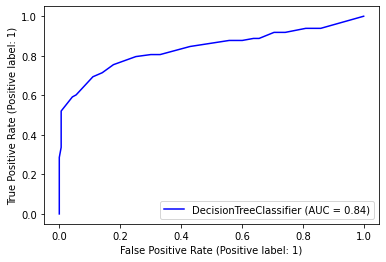

In [105]:
plot_roc_curve(dec_tree, x_test, y_test,
               color="blue")
plt.savefig("figure_eighteen_dec_tree_roc.png")

The ROC Curve for the decision tree model is better than those
of the baseline and SGD classifier models, but slightly worse than
that of the logistic regression model; the same follows for the
AUC score.

Our last model will be a K-Nearest Neighbors model. A K-Nearest
Neighbors (KNN) model uses a relatively straightforward approach:
for any given data point, the algorithm inspects its k-nearest
"neighbors" (closest data points) and labels the data point being
classified using the most common class name among these k-nearest
neighbors. Before we make our model, let's try to determine what
value of k will make our model the most accurate.

In [106]:
# source of idea: https://www.geeksforgeeks.org/k-nearest-neighbor-algorithm-in-python/
neighbors = np.arange(1, 8)
training_accuracy = np.empty(7)
testing_accuracy = np.empty(7)

In [107]:
# source of idea: https://www.geeksforgeeks.org/k-nearest-neighbor-algorithm-in-python/
for k in range(1, 8):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)

    training_accuracy[k - 1] = knn.score(x_train, y_train)
    testing_accuracy[k - 1] = knn.score(x_test, y_test)

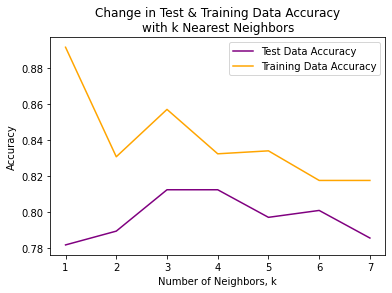

In [108]:
# source of idea: https://www.geeksforgeeks.org/k-nearest-neighbor-algorithm-in-python/
plt.plot(neighbors, testing_accuracy,
         label="Test Data Accuracy",
         color="purple")
plt.plot(neighbors, training_accuracy,
         label="Training Data Accuracy",
         color="orange")
plt.legend(loc="upper right")
plt.xlabel("Number of Neighbors, k")
plt.ylabel("Accuracy")
plt.title("Change in Test & Training Data Accuracy\nwith k Nearest Neighbors")

plt.savefig("figure_nineteen_knn_k_det_plot.png")

Based on our most recent plot, it looks like the value of k that makes
the KNN model the most accurate is k = 3. Therefore, we should use
this value of k in creating our KNN model.

In [109]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
y_predict_knn = knn.predict(x_test)

In [110]:
conf_matrix_knn = confusion_matrix(y_test,
                                   y_predict_knn,
                                   labels=[1, 0])
conf_matrix_knn = c_matrix(conf_matrix_knn)
conf_matrix_knn

,Predicted True,Predicted False
Actual True,68,30
Actual False,19,144


The KNN model predicted 68 true positives, 144 true negatives,
30 false negatives, and 19 false positives.

In [111]:
print(f"Accuracy: {accuracy_score(y_test, y_predict_knn)}")
print(f"Precision: {precision_score(y_test, y_predict_knn)}")
print(f"Recall: {recall_score(y_test, y_predict_knn)}")
print(f"F-Score: {f1_score(y_test, y_predict_knn)}")

Accuracy: 0.8122605363984674
Precision: 0.7816091954022989
Recall: 0.6938775510204082
F-Score: 0.7351351351351352


The KNN model's accuracy is one of the highest of the four
(non-baseline) models we've created, second only to the accuracy
of the decision tree model; it is the same with the KNN model's
precision score. Surprisingly, the KNN model's recall seem to be exactly
the same, creating a tie for the lowest recall score of the four models
(not including the baseline). The overall F-score of the KNN model
is also the second highest of all four (non-baseline) models we've created.

In [112]:
y_predict_knn_probability = knn.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_predict_knn_probability)
auc_knn = roc_auc_score(y_test, y_predict_knn_probability)

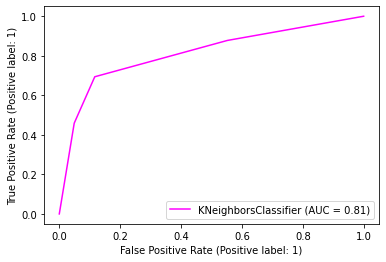

In [113]:
plot_roc_curve(knn, x_test, y_test,
               color="magenta")
plt.savefig("figure_twenty_knn_roc.png")

The ROC curve of the KNN model seems to be in the middle: better than
the SGD classifier and baseline ROC Curves, but worse than the
logistic regression and decision tree ROC Curves; the same
is true for the ROC Curve's AUC score.

Overall, each of our four (non-baseline) models seem to be better
at predicting a passenger's fate than the baseline model. However,
let's try to use cross validation to test our models further. We can
use the K-fold method to do this. Let's start with our (non-baseline)
logistic regression model.

In [114]:
k_fold = KFold(n_splits=5)

In [115]:
log_reg_accuracies = []
log_reg_precisions = []
log_reg_recalls = []
log_reg_f_scores = []

for train_index, test_index in k_fold.split(x_train):
    x_cross_train, x_cross_test = x_train.iloc[train_index,:], x_train.iloc[test_index,:]
    y_cross_train, y_cross_test = y_train.iloc[train_index], y_train.iloc[test_index]

    log_reg.fit(x_cross_train, y_cross_train)
    y_cross_predict_log_reg = log_reg.predict(x_cross_test)

    log_reg_accuracies.append(accuracy_score(y_cross_test,
                                             y_cross_predict_log_reg))
    log_reg_precisions.append(precision_score(y_cross_test,
                                              y_cross_predict_log_reg))
    log_reg_recalls.append(recall_score(y_cross_test,
                                        y_cross_predict_log_reg))
    log_reg_f_scores.append(f1_score(y_cross_test,
                                     y_cross_predict_log_reg))

print("Logistic Regression K-Fold Cross Validation:\n")

for index in range(0, len(log_reg_accuracies)):
    print(f"Fold {index + 1} Accuracy: {log_reg_accuracies[index]}")
    print(f"Fold {index + 1} Precision: {log_reg_precisions[index]}")
    print(f"Fold {index + 1} Recall: {log_reg_recalls[index]}")
    print(f"Fold {index + 1} F-score: {log_reg_f_scores[index]}\n")

print(f"K-Fold Average Accuracy: {sum(log_reg_accuracies) / len(log_reg_accuracies)}")
print(f"K-Fold Average Precision: {sum(log_reg_precisions) / len(log_reg_precisions)}")
print(f"K-Fold Average Recall: {sum(log_reg_recalls) / len(log_reg_recalls)}")
print(f"K-Fold Average F-score: {sum(log_reg_f_scores) / len(log_reg_f_scores)}\n")

print(f"Difference Between K-Fold Average Accuracy and Standard Accuracy: {(sum(log_reg_accuracies) / len(log_reg_accuracies)) - accuracy_score(y_test, y_predict_log_reg)}")
print(f"Difference Between K-Fold Average Precision and Standard Precision: {(sum(log_reg_precisions) / len(log_reg_precisions)) - precision_score(y_test, y_predict_log_reg)}")
print(f"Difference Between K-Fold Average Recall and Standard Recall: {(sum(log_reg_recalls) / len(log_reg_recalls)) - recall_score(y_test, y_predict_log_reg)}")
print(f"Difference Between K-Fold Average F-score and Standard F-score: {(sum(log_reg_f_scores) / len(log_reg_f_scores)) - f1_score(y_test, y_predict_log_reg)}")

Logistic Regression K-Fold Cross Validation:

Fold 1 Accuracy: 0.7868852459016393
Fold 1 Precision: 0.7692307692307693
Fold 1 Recall: 0.6382978723404256
Fold 1 F-score: 0.6976744186046512

Fold 2 Accuracy: 0.7540983606557377
Fold 2 Precision: 0.6590909090909091
Fold 2 Recall: 0.6590909090909091
Fold 2 F-score: 0.6590909090909091

Fold 3 Accuracy: 0.7950819672131147
Fold 3 Precision: 0.7272727272727273
Fold 3 Recall: 0.7111111111111111
Fold 3 F-score: 0.7191011235955056

Fold 4 Accuracy: 0.7851239669421488
Fold 4 Precision: 0.7692307692307693
Fold 4 Recall: 0.7407407407407407
Fold 4 F-score: 0.7547169811320754

Fold 5 Accuracy: 0.7520661157024794
Fold 5 Precision: 0.7631578947368421
Fold 5 Recall: 0.58
Fold 5 F-score: 0.6590909090909091

K-Fold Average Accuracy: 0.7746511312830239
K-Fold Average Precision: 0.7375966139124034
K-Fold Average Recall: 0.6658481266566373
K-Fold Average F-score: 0.69793486830281

Difference Between K-Fold Average Accuracy and Standard Accuracy: -0.02228373461

Based on the previous step's results, it appears that the K-Fold
cross validation (with k = 5) yielded average accuracy, average recall,
and average F-score lower than the model without cross validation's accuracy,
recall, and F-score. However, cross validation also yielded greater average
precision than the original model's precision.

Now, let's try the same analysis with the SGD classifier.

In [116]:
stoch_grad_desc_accuracies = []
stoch_grad_desc_precisions = []
stoch_grad_desc_recalls = []
stoch_grad_desc_f_scores = []

for train_index, test_index in k_fold.split(x_train):
    x_cross_train, x_cross_test = x_train.iloc[train_index,:], x_train.iloc[test_index,:]
    y_cross_train, y_cross_test = y_train.iloc[train_index], y_train.iloc[test_index]

    stoch_grad_desc.fit(x_cross_train, y_cross_train)
    y_cross_predict_stoch_grad_desc = stoch_grad_desc.predict(x_cross_test)

    stoch_grad_desc_accuracies.append(accuracy_score(y_cross_test,
                                             y_cross_predict_stoch_grad_desc))
    stoch_grad_desc_precisions.append(precision_score(y_cross_test,
                                              y_cross_predict_stoch_grad_desc))
    stoch_grad_desc_recalls.append(recall_score(y_cross_test,
                                        y_cross_predict_stoch_grad_desc))
    stoch_grad_desc_f_scores.append(f1_score(y_cross_test,
                                     y_cross_predict_stoch_grad_desc))

print("Stochastic Gradient Descent Classifier K-Fold Cross Validation:\n")

for index in range(0, len(stoch_grad_desc_accuracies)):
    print(f"Fold {index + 1} Accuracy: {stoch_grad_desc_accuracies[index]}")
    print(f"Fold {index + 1} Precision: {stoch_grad_desc_precisions[index]}")
    print(f"Fold {index + 1} Recall: {stoch_grad_desc_recalls[index]}")
    print(f"Fold {index + 1} F-score: {stoch_grad_desc_f_scores[index]}\n")

print(f"K-Fold Average Accuracy: {sum(stoch_grad_desc_accuracies) / len(stoch_grad_desc_accuracies)}")
print(f"K-Fold Average Precision: {sum(stoch_grad_desc_precisions) / len(stoch_grad_desc_precisions)}")
print(f"K-Fold Average Recall: {sum(stoch_grad_desc_recalls) / len(stoch_grad_desc_recalls)}")
print(f"K-Fold Average F-score: {sum(stoch_grad_desc_f_scores) / len(stoch_grad_desc_f_scores)}\n")

print(f"Difference Between K-Fold Average Accuracy and Standard Accuracy: {(sum(stoch_grad_desc_accuracies) / len(stoch_grad_desc_accuracies)) - accuracy_score(y_test, y_predict_stoch_grad_desc)}")
print(f"Difference Between K-Fold Average Precision and Standard Precision: {(sum(stoch_grad_desc_precisions) / len(stoch_grad_desc_precisions)) - precision_score(y_test, y_predict_stoch_grad_desc)}")
print(f"Difference Between K-Fold Average Recall and Standard Recall: {(sum(stoch_grad_desc_recalls) / len(stoch_grad_desc_recalls)) - recall_score(y_test, y_predict_stoch_grad_desc)}")
print(f"Difference Between K-Fold Average F-score and Standard F-score: {(sum(stoch_grad_desc_f_scores) / len(stoch_grad_desc_f_scores)) - f1_score(y_test, y_predict_stoch_grad_desc)}")

Stochastic Gradient Descent Classifier K-Fold Cross Validation:

Fold 1 Accuracy: 0.7950819672131147
Fold 1 Precision: 0.8055555555555556
Fold 1 Recall: 0.6170212765957447
Fold 1 F-score: 0.6987951807228916

Fold 2 Accuracy: 0.6721311475409836
Fold 2 Precision: 0.53125
Fold 2 Recall: 0.7727272727272727
Fold 2 F-score: 0.6296296296296297

Fold 3 Accuracy: 0.7868852459016393
Fold 3 Precision: 0.9130434782608695
Fold 3 Recall: 0.4666666666666667
Fold 3 F-score: 0.6176470588235294

Fold 4 Accuracy: 0.7520661157024794
Fold 4 Precision: 0.7222222222222222
Fold 4 Recall: 0.7222222222222222
Fold 4 F-score: 0.7222222222222222

Fold 5 Accuracy: 0.6942148760330579
Fold 5 Precision: 0.782608695652174
Fold 5 Recall: 0.36
Fold 5 F-score: 0.4931506849315068

K-Fold Average Accuracy: 0.740075870478255
K-Fold Average Precision: 0.7509359903381643
K-Fold Average Recall: 0.5877274876423813
K-Fold Average F-score: 0.6322889552659559

Difference Between K-Fold Average Accuracy and Standard Accuracy: -0.026

Similar to the result of our logistic regression model's cross validation,
it appears that the average Accuracy, Recall, and F-score are worse, while
the average Precision is better.

Next, let's cross validate the decision tree model.

In [117]:
dec_tree_accuracies = []
dec_tree_precisions = []
dec_tree_recalls = []
dec_tree_f_scores = []

for train_index, test_index in k_fold.split(x_train):
    x_cross_train, x_cross_test = x_train.iloc[train_index,:], x_train.iloc[test_index,:]
    y_cross_train, y_cross_test = y_train.iloc[train_index], y_train.iloc[test_index]

    dec_tree.fit(x_cross_train, y_cross_train)
    y_cross_predict_dec_tree = dec_tree.predict(x_cross_test)

    dec_tree_accuracies.append(accuracy_score(y_cross_test,
                                             y_cross_predict_dec_tree))
    dec_tree_precisions.append(precision_score(y_cross_test,
                                              y_cross_predict_dec_tree))
    dec_tree_recalls.append(recall_score(y_cross_test,
                                        y_cross_predict_dec_tree))
    dec_tree_f_scores.append(f1_score(y_cross_test,
                                     y_cross_predict_dec_tree))

print("Decision Tree K-Fold Cross Validation:\n")

for index in range(0, len(dec_tree_accuracies)):
    print(f"Fold {index + 1} Accuracy: {dec_tree_accuracies[index]}")
    print(f"Fold {index + 1} Precision: {dec_tree_precisions[index]}")
    print(f"Fold {index + 1} Recall: {dec_tree_recalls[index]}")
    print(f"Fold {index + 1} F-score: {dec_tree_f_scores[index]}\n")

print(f"K-Fold Average Accuracy: {sum(dec_tree_accuracies) / len(dec_tree_accuracies)}")
print(f"K-Fold Average Precision: {sum(dec_tree_precisions) / len(dec_tree_precisions)}")
print(f"K-Fold Average Recall: {sum(dec_tree_recalls) / len(dec_tree_recalls)}")
print(f"K-Fold Average F-score: {sum(dec_tree_f_scores) / len(dec_tree_f_scores)}\n")

print(f"Difference Between K-Fold Average Accuracy and Standard Accuracy: {(sum(dec_tree_accuracies) / len(dec_tree_accuracies)) - accuracy_score(y_test, y_predict_dec_tree)}")
print(f"Difference Between K-Fold Average Precision and Standard Precision: {(sum(dec_tree_precisions) / len(dec_tree_precisions)) - precision_score(y_test, y_predict_dec_tree)}")
print(f"Difference Between K-Fold Average Recall and Standard Recall: {(sum(dec_tree_recalls) / len(dec_tree_recalls)) - recall_score(y_test, y_predict_dec_tree)}")
print(f"Difference Between K-Fold Average F-score and Standard F-score: {(sum(dec_tree_f_scores) / len(dec_tree_f_scores)) - f1_score(y_test, y_predict_dec_tree)}")

Decision Tree K-Fold Cross Validation:

Fold 1 Accuracy: 0.7786885245901639
Fold 1 Precision: 0.7631578947368421
Fold 1 Recall: 0.6170212765957447
Fold 1 F-score: 0.6823529411764706

Fold 2 Accuracy: 0.7950819672131147
Fold 2 Precision: 0.7435897435897436
Fold 2 Recall: 0.6590909090909091
Fold 2 F-score: 0.6987951807228915

Fold 3 Accuracy: 0.819672131147541
Fold 3 Precision: 0.7446808510638298
Fold 3 Recall: 0.7777777777777778
Fold 3 F-score: 0.7608695652173912

Fold 4 Accuracy: 0.7768595041322314
Fold 4 Precision: 0.8
Fold 4 Recall: 0.6666666666666666
Fold 4 F-score: 0.7272727272727272

Fold 5 Accuracy: 0.743801652892562
Fold 5 Precision: 0.8064516129032258
Fold 5 Recall: 0.5
Fold 5 F-score: 0.6172839506172839

K-Fold Average Accuracy: 0.7828207559951226
K-Fold Average Precision: 0.7715760204587283
K-Fold Average Recall: 0.6441113260262197
K-Fold Average F-score: 0.6973148730013529

Difference Between K-Fold Average Accuracy and Standard Accuracy: -0.033271198027865934
Difference Bet

Unlike the previous two cross validations, the cross valiation of
the decision tree model has yielded worse average scores all around:
the average accuracy, precision, recall, and F-score are all worse than
accuracy, precision, recall, and F-score of the original non-cross
validated model.

Finally, let us cross validate our k-nearest neighbor model.

In [118]:
knn_accuracies = []
knn_precisions = []
knn_recalls = []
knn_f_scores = []

for train_index, test_index in k_fold.split(x_train):
    x_cross_train, x_cross_test = x_train.iloc[train_index,:], x_train.iloc[test_index,:]
    y_cross_train, y_cross_test = y_train.iloc[train_index], y_train.iloc[test_index]

    knn.fit(x_cross_train, y_cross_train)
    y_cross_predict_knn = knn.predict(x_cross_test)

    knn_accuracies.append(accuracy_score(y_cross_test, y_cross_predict_knn))
    knn_precisions.append(precision_score(y_cross_test, y_cross_predict_knn))
    knn_recalls.append(recall_score(y_cross_test, y_cross_predict_knn))
    knn_f_scores.append(f1_score(y_cross_test, y_cross_predict_knn))

print("K-Nearest Neighbor K-Fold Cross Validation:\n")

for index in range(0, len(knn_accuracies)):
    print(f"Fold {index + 1} Accuracy: {knn_accuracies[index]}")
    print(f"Fold {index + 1} Precision: {knn_precisions[index]}")
    print(f"Fold {index + 1} Recall: {knn_recalls[index]}")
    print(f"Fold {index + 1} F-score: {knn_f_scores[index]}\n")

print(f"K-Fold Average Accuracy: {sum(knn_accuracies) / len(knn_accuracies)}")
print(f"K-Fold Average Precision: {sum(knn_precisions) / len(knn_precisions)}")
print(f"K-Fold Average Recall: {sum(knn_recalls) / len(knn_recalls)}")
print(f"K-Fold Average F-score: {sum(knn_f_scores) / len(knn_f_scores)}\n")

print(f"Difference Between K-Fold Average Accuracy and Standard Accuracy: {(sum(knn_accuracies) / len(knn_accuracies)) - accuracy_score(y_test, y_predict_knn)}")
print(f"Difference Between K-Fold Average Precision and Standard Precision: {(sum(knn_precisions) / len(knn_precisions)) - precision_score(y_test, y_predict_knn)}")
print(f"Difference Between K-Fold Average Recall and Standard Recall: {(sum(knn_recalls) / len(knn_recalls)) - recall_score(y_test, y_predict_knn)}")
print(f"Difference Between K-Fold Average F-score and Standard F-score: {(sum(knn_f_scores) / len(knn_f_scores)) - f1_score(y_test, y_predict_knn)}")

K-Nearest Neighbor K-Fold Cross Validation:

Fold 1 Accuracy: 0.7459016393442623
Fold 1 Precision: 0.6739130434782609
Fold 1 Recall: 0.6595744680851063
Fold 1 F-score: 0.6666666666666667

Fold 2 Accuracy: 0.7868852459016393
Fold 2 Precision: 0.7142857142857143
Fold 2 Recall: 0.6818181818181818
Fold 2 F-score: 0.6976744186046512

Fold 3 Accuracy: 0.7950819672131147
Fold 3 Precision: 0.7272727272727273
Fold 3 Recall: 0.7111111111111111
Fold 3 F-score: 0.7191011235955056

Fold 4 Accuracy: 0.7768595041322314
Fold 4 Precision: 0.7454545454545455
Fold 4 Recall: 0.7592592592592593
Fold 4 F-score: 0.7522935779816514

Fold 5 Accuracy: 0.7768595041322314
Fold 5 Precision: 0.7804878048780488
Fold 5 Recall: 0.64
Fold 5 F-score: 0.7032967032967035

K-Fold Average Accuracy: 0.7763175721446959
K-Fold Average Precision: 0.7282827670738594
K-Fold Average Recall: 0.6903526040547316
K-Fold Average F-score: 0.7078064980290357

Difference Between K-Fold Average Accuracy and Standard Accuracy: -0.0359429642

Like the decision tree model's cross validation, the cross validation
of the k-nearest neighbor model has also yielded worse average
accuracy, precision, recall, and F-score.

One possible reason that the cross validations of these four models
have yielded generally worse evaluation statistics than the
original non-cross validated models is because our models might be overfitted.
In other words, we may have too many data features in the parameters
of our models. A good way to determine if this theory is accurate is to
tweak the parameters of our models and see if these changes affect
the evaluation statistics, either in the original models and in the
cross validations of each model.

Choosing which of our models is the best is not a very straightforward
task: there are five different numeric evaluation statistics that we could
base such a decision on, and the use of each one might result in a different
decision. Therefore, we will allow the reader to make their own
determinations as to what model(s) are the best.

The last step is to evaluate our models on the testing data.
We will use this data on each of the models (including the baseline
model) and save the results each time into a DataFrame.

In [119]:
def save_to_data_frame(y_pred):
    temp_dict = {
        "Pclass" : test_data["Pclass"],
        "Sex" : test_data["Sex"],
        "SibSp" : test_data["SibSp"],
        "log(Fare)" : test_data["log(Fare)"],
        "Predicted Survived" : y_pred
    }

    return pd.DataFrame.from_dict(temp_dict)

In [120]:
data_frames = []
data_frames_names = ["Baseline Logistic Regression Model",
                     "Logistic Regression Model",
                     "Stochastic Gradient Descent Classifier",
                     "Decision Tree Model",
                     "K-Nearest Neighbor Model"]

x_eval_baseline = test_data[["Pclass", "log(Fare)"]]
y_eval_pred = baseline_log_reg.predict(x_eval_baseline)

baseline_dict = {
    "Pclass" : test_data["Pclass"],
    "log(Fare)" : test_data["log(Fare)"],
    "Predicted Survival" : y_eval_pred
}

data_frames.append(pd.DataFrame.from_dict(baseline_dict))

In [121]:
x_eval = test_data[["Pclass", "Sex", "SibSp", "log(Fare)"]]

models = [baseline_log_reg, log_reg, stoch_grad_desc, dec_tree, knn]
for index in range(1, 5):
    y_pred = models[index].predict(x_eval)
    data_frames.append(save_to_data_frame(y_pred))

In [122]:
data_frames[0].head(20)

,Pclass,log(Fare),Predicted Survival
0,3,2.057860,0
1,3,1.945910,0
2,2,2.270836,0
3,3,2.159003,0
4,3,2.508582,0
5,3,2.221917,0
6,3,2.031983,0
7,2,3.367296,0
8,3,1.978128,0
9,3,3.184284,0


In [123]:
data_frames[1].head(20)

,Pclass,Sex,SibSp,log(Fare),Predicted Survived
0,3,0,0,2.057860,0
1,3,1,1,1.945910,1
2,2,0,0,2.270836,0
3,3,0,0,2.159003,0
4,3,1,1,2.508582,1
5,3,0,0,2.221917,0
6,3,1,0,2.031983,1
7,2,0,1,3.367296,0
8,3,1,0,1.978128,1
9,3,0,2,3.184284,0


In [124]:
data_frames[2].head(20)

,Pclass,Sex,SibSp,log(Fare),Predicted Survived
0,3,0,0,2.057860,0
1,3,1,1,1.945910,0
2,2,0,0,2.270836,0
3,3,0,0,2.159003,0
4,3,1,1,2.508582,0
5,3,0,0,2.221917,0
6,3,1,0,2.031983,1
7,2,0,1,3.367296,0
8,3,1,0,1.978128,1
9,3,0,2,3.184284,0


In [125]:
data_frames[3].head(20)

,Pclass,Sex,SibSp,log(Fare),Predicted Survived
0,3,0,0,2.057860,0
1,3,1,1,1.945910,1
2,2,0,0,2.270836,0
3,3,0,0,2.159003,0
4,3,1,1,2.508582,0
5,3,0,0,2.221917,0
6,3,1,0,2.031983,1
7,2,0,1,3.367296,0
8,3,1,0,1.978128,1
9,3,0,2,3.184284,0


In [126]:
data_frames[4].head(20)

,Pclass,Sex,SibSp,log(Fare),Predicted Survived
0,3,0,0,2.057860,0
1,3,1,1,1.945910,0
2,2,0,0,2.270836,0
3,3,0,0,2.159003,0
4,3,1,1,2.508582,0
5,3,0,0,2.221917,0
6,3,1,0,2.031983,1
7,2,0,1,3.367296,0
8,3,1,0,1.978128,1
9,3,0,2,3.184284,0


In [127]:
# DO NOT UNCOMMENT, FOR USE ON CHARLES' COMPUTER DURING DEMO!

# for index in range(0,len(data_frames)):
#     data_frames[index].to_csv(r"C:\Users\Username\Path\Directory\{}.csv".format(data_frames_names[index]))

